In [150]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [151]:
import sys
import os
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import pyarrow.parquet as pq
import scipy
from scipy import sparse as sp
import implicit
import re
import bisect
import sklearn.metrics as m
import catboost
from catboost import *
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV

import torch
from transformers import AutoTokenizer, AutoModel

import phik
from phik.report import plot_correlation_matrix
from phik import report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torch.optim as optim

In [153]:
print(catboost.__version__)
!python --version

1.0.6
Python 3.10.4


In [154]:
LOCAL_DATA_PATH = './context_data/'
SPLIT_SEED = 42
DATA_FILE = 'competition_data_final_pqt'
TARGET_FILE = 'public_train.pqt'
SUBMISSION_FILE = 'submit.pqt'
COLUMNS_NO_URL = ['region_name','city_name','cpe_manufacturer_name','cpe_model_name','cpe_type_cd','cpe_model_os_type','price','part_of_day','user_id']
CATEGORICAL_FEATURES=['region_name','city_name','cpe_manufacturer_name','cpe_model_name','cpe_type_cd','cpe_model_os_type','part_of_day']

## Чтение данных

### id_to_submit

In [155]:
id_to_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas()

In [156]:
id_to_submit.head(2)

,user_id
221301,221301
31271,31271


In [157]:
id_to_submit.shape

(144724, 1)

### targets

In [158]:
targets = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}').to_pandas()

In [159]:
targets.head(2)

,age,is_male,user_id
350459,31.0,1,350459
188276,35.0,1,188276


### data

In [ ]:
data = pq.read_table(f'{LOCAL_DATA_PATH}/{DATA_FILE}').to_pandas()

In [ ]:
data.info()

In [ ]:
data.head(2)

Регион   
, населенный пункт   
, производиель устройства   
, модель устроства   
, домен, с которого пришел рекламный запрос   
, тип устройства (смартфон или что-то другое)   
, операционка на устройстве   
, оценка цены устройства   
, дата   
, время дня (утро, вечер ...)   
, число запросов   
, id пользователя   

## Предобработка данных

### Targets

#### age

In [160]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270000 entries, 350459 to 103148
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   age      269999 non-null  float64
 1   is_male  269958 non-null  object 
 2   user_id  270000 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 8.2+ MB


In [161]:
targets.dropna(inplace=True)
targets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269957 entries, 350459 to 103148
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   age      269957 non-null  float64
 1   is_male  269957 non-null  object 
 2   user_id  269957 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 8.2+ MB


**В задаче требуется определять возраст с 18 лет, понизим данное значение для первого баккета до 16 лет.**

In [162]:
def age_bucket(x):
    return bisect.bisect_left([1,25,35,45,55,65], x)

In [163]:
targets['age_target'] = targets['age'].map(age_bucket)

**Разбивка на группы по возрастам корректная**

In [164]:
targets['age_target'].value_counts()

2    87270
3    77486
4    42442
1    33647
5    23580
6     5503
0       29
Name: age_target, dtype: int64

In [165]:
targets = targets[targets['age_target'] != 0]

<AxesSubplot:>

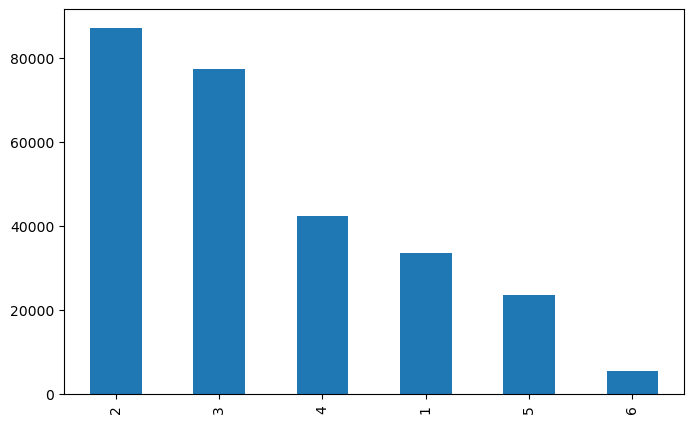

In [166]:
targets['age_target'].value_counts().plot(kind='bar',figsize=(8,5), alpha=1)

#### is_male

In [167]:
targets['is_male'].value_counts()

1     135314
0     128982
NA      5632
Name: is_male, dtype: int64

In [168]:
targets = targets[targets['is_male'] != 'NA']

In [169]:
targets['is_male'].value_counts()

1    135314
0    128982
Name: is_male, dtype: int64

**Много удалил NA!**

#### готовый target

In [170]:
targets = targets.astype('int')

In [171]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264296 entries, 350459 to 103148
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   age         264296 non-null  int32
 1   is_male     264296 non-null  int32
 2   user_id     264296 non-null  int32
 3   age_target  264296 non-null  int32
dtypes: int32(4)
memory usage: 6.0 MB


In [172]:
targets.head(2)

,age,is_male,user_id,age_target
350459,31,1,350459,2
188276,35,1,188276,2


### Data

### Создание признака день недели

In [ ]:
data['day_of_week'] = pd.to_datetime(data['date']).dt.dayofweek
data['day_of_week'] = data['day_of_week'].astype('str')

In [ ]:
data[['user_id','day_of_week','part_of_day']].to_parquet('data_day_of_week_part_of_day.pqt')

#### url_host only v.2

In [37]:
data_url_only = data[['user_id','url_host']]

In [38]:
def clip_domain(url):
    if url == None:
        return 'None'
    else:
        list_subdomain = url.split('.')
        if len(list_subdomain) > 3:
            return f'{list_subdomain[-4]}{list_subdomain[-3]}{list_subdomain[-2]}{list_subdomain[-1]}'
        if len(list_subdomain) == 3:
            return f'{list_subdomain[-3]}{list_subdomain[-2]}{list_subdomain[-1]}'
        if len(list_subdomain) == 2:
            return f'{list_subdomain[-2]}{list_subdomain[-1]}'
        if len(list_subdomain) < 2:
            return f'{list_subdomain[-1]}'

In [39]:
%%time
data_url_only['url_host'] = data_url_only['url_host'].apply(clip_domain)
data_url_only.to_parquet('data_url_only.pqt')

CPU times: total: 4min 30s
Wall time: 4min 30s


##### ПРИЗНАК текстовый на имени домана 2 уровня

In [39]:
data_url_only = pq.read_table(f'data_url_only.pqt').to_pandas()

In [92]:
def creat_text(row):

    return " ".join(row)

In [93]:
%%time
feature_url_only_XX_2_domains_without_dot_text = data_url_only.groupby('user_id')['url_host'].agg(['unique'])
feature_url_only_XX_2_domains_without_dot_text['text_2_domains'] = feature_url_only_XX_2_domains_without_dot_text['unique'].apply(creat_text)
feature_url_only_XX_2_domains_without_dot_text.drop(columns = ['unique'], inplace=True)
feature_url_only_XX_2_domains_without_dot_text['user_id']=feature_url_only_XX_2_domains_without_dot_text.index
feature_url_only_XX_2_domains_without_dot_text.to_parquet('feature_url_only_XX_2_domains_without_dot_text_v2.pqt')

CPU times: total: 56.3 s
Wall time: 56.3 s


In [94]:
feature_url_only_XX_2_domains_without_dot_text

,text_2_domains,user_id
user_id,,
0,s02mdnnet avatarsmdsyandexnet googleadsgdouble...,0
1,avatarsmdsyandexnet iytimgcom adsbetweendigita...,1
2,lentarumediaeagleplatformcom iytimgcom node1on...,2
3,admailru avatarsmdsyandexnet mailyandexru pozd...,3
4,kpmd yastaticnet avatarsmdsyandexnet sun9-85us...,4
...,...,...
415312,googleadsgdoubleclicknet,415312
415313,avatarsmdsyandexnet,415313
415314,vkcom,415314


##### ПРИЗНАКИ текстовые на имени домана 2 уровня для дней недели и времени дня

In [6]:
data_url_only = pq.read_table(f'data_url_only.pqt').to_pandas()
data_day_of_week_part_of_day = pq.read_table(f'data_day_of_week_part_of_day.pqt').to_pandas()
data = pd.concat((data_url_only,
                  data_day_of_week_part_of_day.drop('user_id', axis=1),
                ), axis=1)
data.head(2)

,user_id,url_host,day_of_week,part_of_day
0,45098,adadriverru,2,morning
1,45098,applecom,6,morning


In [7]:
def creat_text(row):

    return " ".join(row)

In [8]:
for day_of_week in tqdm(['0','1','2','3','4','5','6']):
    for part_of_day in ['morning','day','evening','night']:
        data_temp = data[['user_id','url_host','day_of_week','part_of_day']]
        data_temp.loc[(data_temp['day_of_week'] != day_of_week) | (data_temp['part_of_day'] != part_of_day), 'url_host'] = ''
        feature = data_temp.groupby('user_id')['url_host'].agg(['unique'])
        feature[f'text_day_{day_of_week}_{part_of_day}'] = feature['unique'].apply(creat_text)
        feature.drop(columns = ['unique'], inplace=True)
        feature['user_id']=feature.index
        feature.to_parquet(f'feature_url_only_text_day_{day_of_week}_{part_of_day}.pqt')
        

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [42:16<00:00, 362.33s/it]


##### ПРИЗНАКИ текстовые на имени домана 2 уровня для рабочих дней недели и времени дня

In [73]:
data_url_only = pq.read_table(f'data_url_only.pqt').to_pandas()
data_day_of_week_part_of_day = pq.read_table(f'data_day_of_week_part_of_day.pqt').to_pandas()
data = pd.concat((data_url_only,
                  data_day_of_week_part_of_day.drop('user_id', axis=1),
                ), axis=1)
data.head(2)

,user_id,url_host,day_of_week,part_of_day
0,45098,adadriverru,2,morning
1,45098,applecom,6,morning


In [74]:
def creat_text(row):

    return " ".join(row)

In [75]:
for part_of_day in tqdm(['morning','day','evening','night']):
    data_temp = data[['user_id','url_host','day_of_week','part_of_day']]
    data_temp.loc[(data_temp['day_of_week'] == '5') | (data_temp['day_of_week'] == '6') | (data_temp['part_of_day'] != part_of_day), 'url_host'] = ''
    feature = data_temp.groupby('user_id')['url_host'].agg(['unique'])
    feature[f'text_workday_{part_of_day}'] = feature['unique'].apply(creat_text)
    feature.drop(columns = ['unique'], inplace=True)
    feature['user_id']=feature.index
    feature.to_parquet(f'feature_url_only_text_workday_{part_of_day}.pqt')

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [08:02<00:00, 120.75s/it]


##### ПРИЗНАКИ текстовые на имени домана 2 уровня для выходных дней недели и времени дня

In [76]:
data_url_only = pq.read_table(f'data_url_only.pqt').to_pandas()
data_day_of_week_part_of_day = pq.read_table(f'data_day_of_week_part_of_day.pqt').to_pandas()
data = pd.concat((data_url_only,
                  data_day_of_week_part_of_day.drop('user_id', axis=1),
                ), axis=1)
data.head(2)

,user_id,url_host,day_of_week,part_of_day
0,45098,adadriverru,2,morning
1,45098,applecom,6,morning


In [77]:
def creat_text(row):

    return " ".join(row)

In [78]:
for part_of_day in tqdm(['morning','day','evening','night']):
    data_temp = data[['user_id','url_host','day_of_week','part_of_day']]
    data_temp.loc[((data_temp['day_of_week'] != '5') & (data_temp['day_of_week'] != '6')) | (data_temp['part_of_day'] != part_of_day), 'url_host'] = ''
    feature = data_temp.groupby('user_id')['url_host'].agg(['unique'])
    feature[f'text_weekend_{part_of_day}'] = feature['unique'].apply(creat_text)
    feature.drop(columns = ['unique'], inplace=True)
    feature['user_id']=feature.index
    feature.to_parquet(f'feature_url_only_text_weekend_{part_of_day}.pqt')

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [07:49<00:00, 117.36s/it]


##### ПРИЗНАКИ текстовые на имени домена 2 уровня для времени дня

In [79]:
data_url_only = pq.read_table(f'data_url_only.pqt').to_pandas()
data_day_of_week_part_of_day = pq.read_table(f'data_day_of_week_part_of_day.pqt').to_pandas()
data = pd.concat((data_url_only,
                  data_day_of_week_part_of_day.drop('user_id', axis=1),
                ), axis=1)
data.head(2)

,user_id,url_host,day_of_week,part_of_day
0,45098,adadriverru,2,morning
1,45098,applecom,6,morning


In [80]:
def creat_text(row):

    return " ".join(row)

In [81]:
for part_of_day in tqdm(['morning','day','evening','night']):
    data_temp = data[['user_id','url_host','part_of_day']]
    data_temp.loc[(data_temp['part_of_day'] != part_of_day), 'url_host'] = ''
    feature = data_temp.groupby('user_id')['url_host'].agg(['unique'])
    feature[f'text_{part_of_day}'] = feature['unique'].apply(creat_text)
    feature.drop(columns = ['unique'], inplace=True)
    feature['user_id']=feature.index
    feature.to_parquet(f'feature_url_only_text_{part_of_day}.pqt')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:42<00:00, 85.53s/it]


##### ПРИЗНАКИ текстовые на имени домена 2 уровня для дней недели

In [82]:
data_url_only = pq.read_table(f'data_url_only.pqt').to_pandas()
data_day_of_week_part_of_day = pq.read_table(f'data_day_of_week_part_of_day.pqt').to_pandas()
data = pd.concat((data_url_only,
                  data_day_of_week_part_of_day.drop('user_id', axis=1),
                ), axis=1)
data.head(2)

,user_id,url_host,day_of_week,part_of_day
0,45098,adadriverru,2,morning
1,45098,applecom,6,morning


In [83]:
def creat_text(row):

    return " ".join(row)

In [84]:
for day_of_week in tqdm(['0','1','2','3','4','5','6']):
        data_temp = data[['user_id','url_host','day_of_week']]
        data_temp.loc[data_temp['day_of_week'] != day_of_week, 'url_host'] = ''
        feature = data_temp.groupby('user_id')['url_host'].agg(['unique'])
        feature[f'text_day_{day_of_week}'] = feature['unique'].apply(creat_text)
        feature.drop(columns = ['unique'], inplace=True)
        feature['user_id']=feature.index
        feature.to_parquet(f'feature_url_only_text_day_{day_of_week}.pqt')

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [09:33<00:00, 81.90s/it]


#### ПРИЗНАК region_city

In [40]:
feature_region_text = data[['user_id','region_name','city_name']]
#data.drop(['region_name','city_name'], axis=1, inplace=True)
feature_region_text = feature_region_text.groupby('user_id')['region_name','city_name'].agg(['unique'])
feature_region_text['region_text'] = ""

NameError: name 'data' is not defined

In [ ]:
# перевод в набор слов списка городов и регионов
def lemmatize_region(unique):

    text = ""
    for i in range(len(unique)):
        text +=unique[i]+' '
    return text

In [ ]:
for i in tqdm(feature_region_text.index):
    text = lemmatize_region(feature_region_text.loc[i,'region_name']['unique']) \
         + lemmatize_region(feature_region_text.loc[i,'city_name']['unique'])
    
    for word in ['область','Республика','край']:
        text = re.sub(word,'',text)
    feature_region_text['region_text'].loc[i] = text     


In [ ]:
feature_region_text = pd.DataFrame(feature_region_text['region_text']).reset_index()
feature_region_text.to_parquet('feature_region_text.pqt')

In [ ]:
feature_region_text.head(2)

#### ПРИЗНАК cpe_manufacturer_name,	cpe_model_name

In [ ]:
feature_manufacturer_model = data[['user_id','cpe_manufacturer_name','cpe_model_name']]
#data.drop(['cpe_manufacturer_name','cpe_model_name','cpe_type_cd','cpe_model_os_type'], axis=1, inplace=True)
feature_manufacturer_model = feature_manufacturer_model.groupby('user_id')['cpe_manufacturer_name','cpe_model_name'].agg(['unique'])
feature_manufacturer_model = pd.DataFrame(feature_manufacturer_model.values).reset_index().rename(columns={'index':'user_id',0:'manufacturer',1:'model'})
for i in tqdm(feature_manufacturer_model.index):
    feature_manufacturer_model['manufacturer'][i] = feature_manufacturer_model['manufacturer'][i][0]
    feature_manufacturer_model['model'][i] = feature_manufacturer_model['model'][i][0]
feature_manufacturer_model.to_parquet('feature_manufacturer_model.pqt')
feature_manufacturer_model.head(2)

#### ПРИЗНАК cpe_type_cd,	cpe_model_os_type

In [ ]:
feature_cpe_os = data[['user_id','cpe_type_cd','cpe_model_os_type']]
#data.drop(['cpe_type_cd','cpe_model_os_type'], axis=1, inplace=True)
feature_cpe_os = feature_cpe_os.groupby('user_id')['cpe_type_cd','cpe_model_os_type'].agg(['unique'])
feature_cpe_os = pd.DataFrame(feature_cpe_os.values).reset_index().rename(columns={'index':'user_id',0:'cpe_type_cd',1:'cpe_model_os_type'})
for i in tqdm(feature_cpe_os.index):
    feature_cpe_os['cpe_type_cd'][i] = feature_cpe_os['cpe_type_cd'][i][0]
    feature_cpe_os['cpe_model_os_type'][i] = feature_cpe_os['cpe_model_os_type'][i][0]
feature_cpe_os.loc[feature_cpe_os['cpe_model_os_type'] == 'Apple iOS','cpe_model_os_type'] = 'iOS'
feature_cpe_os.to_parquet('feature_cpe_os.pqt')
feature_cpe_os.head(2)

#### ПРИЗНАК part_of_day

In [ ]:
feature_part_of_day = data[['user_id','part_of_day']]
#data.drop(['part_of_day'], axis=1, inplace=True)
feature_part_of_day = feature_part_of_day.groupby('user_id')['part_of_day'].agg(['sum'])

In [ ]:
def part_of_day_count(text):
    
        
    morning_count = text.count('morning')
    day_count = text.count('day')
    evening_count = text.count('evening')
    night_count = text.count('night')
    
    all_count = morning_count+day_count+evening_count+night_count
    
    morning_count_norm = morning_count/all_count
    day_count_norm = day_count/all_count
    evening_count_norm = evening_count/all_count
    night_count_norm = night_count/all_count  
    
    return (morning_count, 
            day_count, 
            evening_count, 
            night_count, 
            all_count, 
            morning_count_norm, 
            day_count_norm, 
            evening_count_norm, 
            night_count_norm)

In [ ]:
part_of_day_list = {'user_id': [], 
                    'morning_count': [], 
                    'day_count': [], 
                    'evening_count': [], 
                    'night_count': [], 
                    'all_count': [], 
                    'morning_count_norm': [], 
                    'day_count_norm': [], 
                    'evening_count_norm': [], 
                    'night_count_norm': []}

for i in tqdm(feature_part_of_day.index):
    part_of_day = part_of_day_count(feature_part_of_day.loc[i,'sum'])
    part_of_day_list['user_id'].append(i)
    part_of_day_list['morning_count'].append(part_of_day[0])
    part_of_day_list['day_count'].append(part_of_day[1])
    part_of_day_list['evening_count'].append(part_of_day[2])
    part_of_day_list['night_count'].append(part_of_day[3])
    part_of_day_list['all_count'].append(part_of_day[4])
    part_of_day_list['morning_count_norm'].append(part_of_day[5])
    part_of_day_list['day_count_norm'].append(part_of_day[6])
    part_of_day_list['evening_count_norm'].append(part_of_day[7])
    part_of_day_list['night_count_norm'].append(part_of_day[8])
    
    
feature_part_of_day = pd.DataFrame(data=part_of_day_list)
del part_of_day_list
feature_part_of_day.to_parquet('feature_part_of_day.pqt')

In [ ]:
feature_part_of_day.head(2)

#### ПРИЗНАК part_of_week

In [ ]:
feature_day_of_week = data[['user_id','day_of_week']]
#data.drop(['date'], axis=1, inplace=True)

In [ ]:
feature_day_of_week = feature_day_of_week.groupby('user_id')['day_of_week'].agg(['sum'])

In [ ]:
def day_of_week_count(text):
    
    day_0_count = text.count('0')
    day_1_count = text.count('1')
    day_2_count = text.count('2')
    day_3_count = text.count('3')
    day_4_count = text.count('4')
    day_5_count = text.count('5')
    day_6_count = text.count('6')
    
    day_all_count = day_0_count+day_1_count+day_2_count+day_3_count+day_4_count+day_5_count+day_6_count
    
    day_0_count_norm = day_0_count / day_all_count
    day_1_count_norm = day_1_count / day_all_count
    day_2_count_norm = day_2_count / day_all_count
    day_3_count_norm = day_3_count / day_all_count
    day_4_count_norm = day_4_count / day_all_count
    day_5_count_norm = day_5_count / day_all_count
    day_6_count_norm = day_6_count / day_all_count
    
    
    return (day_0_count, 
            day_1_count, 
            day_2_count, 
            day_3_count, 
            day_4_count, 
            day_5_count, 
            day_6_count, 
            day_all_count, 
            day_0_count_norm, 
            day_1_count_norm,
            day_2_count_norm, 
            day_3_count_norm, 
            day_4_count_norm, 
            day_5_count_norm, 
            day_6_count_norm)

In [ ]:
day_of_week_list = {
    'user_id': [], 
    'day_0_count': [],
    'day_1_count': [],
    'day_2_count': [],
    'day_3_count': [],
    'day_4_count': [],
    'day_5_count': [],
    'day_6_count': [],
    'day_all_count': [],
    'day_0_count_norm': [],
    'day_1_count_norm': [],
    'day_2_count_norm': [],
    'day_3_count_norm': [],
    'day_4_count_norm': [],
    'day_5_count_norm': [],
    'day_6_count_norm': [],
}

for i in tqdm(feature_day_of_week.index):
    day_of_week = day_of_week_count(feature_day_of_week.loc[i,'sum'])
    day_of_week_list['user_id'].append(i)
    day_of_week_list['day_0_count'].append(day_of_week[0])
    day_of_week_list['day_1_count'].append(day_of_week[1])
    day_of_week_list['day_2_count'].append(day_of_week[2])
    day_of_week_list['day_3_count'].append(day_of_week[3])
    day_of_week_list['day_4_count'].append(day_of_week[4])
    day_of_week_list['day_5_count'].append(day_of_week[5])
    day_of_week_list['day_6_count'].append(day_of_week[6])
    day_of_week_list['day_all_count'].append(day_of_week[7])
    day_of_week_list['day_0_count_norm'].append(day_of_week[8])
    day_of_week_list['day_1_count_norm'].append(day_of_week[9])
    day_of_week_list['day_2_count_norm'].append(day_of_week[10])
    day_of_week_list['day_3_count_norm'].append(day_of_week[11])
    day_of_week_list['day_4_count_norm'].append(day_of_week[12])
    day_of_week_list['day_5_count_norm'].append(day_of_week[13])
    day_of_week_list['day_6_count_norm'].append(day_of_week[14])
    
feature_day_of_week = pd.DataFrame(data=day_of_week_list)
del day_of_week_list
feature_day_of_week.to_parquet('feature_day_of_week.pqt')

In [ ]:
feature_day_of_week.head(2)

#### ПРИЗНАК price

In [ ]:
data_price = data[['user_id','price']]
#data.drop(['price'], axis=1, inplace=True)

In [ ]:
data_model = data[['user_id','cpe_model_name']]
data_model = data_model.groupby('user_id')['cpe_model_name'].agg(['unique'])

In [ ]:
feature_price = data_price.groupby('user_id')['price'].agg(['min','max','mean','std'])
user_not_price = feature_price[feature_price['min'].isna()].index.tolist()
model_name = data[['user_id','cpe_model_name']].query('user_id in @user_not_price')['cpe_model_name'].unique()

In [ ]:
feature_price.head()

In [ ]:
data_model_price_list = {
    'model':[],
    'price':[]
}
data_model_price = data[['cpe_model_name','price']]
for model in tqdm(model_name):
    data_model_price_list['model'].append(model)
    data_model_price_list['price'].append(data_model_price[data_model_price['cpe_model_name'] == model]['price'].mean())

In [ ]:
data_model_no_price = pd.DataFrame(data=data_model_price_list)
data_model_no_price.to_parquet('data_model_no_price.pqt')
data_model_no_price = pd.read_parquet(f'data_model_no_price.pqt')

In [ ]:
user_not_price_models = data_model.query('user_id in @user_not_price')
user_not_price_models['mean_price'] = np.nan

In [ ]:
user_not_price_models = pd.DataFrame(user_not_price_models.reset_index().values, columns=('user_id','model','model_price'))

In [ ]:
for i in tqdm(data_model_no_price.index):
    
    user_not_price_models.loc[user_not_price_models['model'] == data_model_no_price.loc[i,'model'], 'model_price'] = data_model_no_price.loc[i,'price']

In [ ]:
user_not_price_models.head()

In [ ]:
feature_price = feature_price.reset_index()

In [ ]:
feature_price.head()

In [ ]:
for i in tqdm(user_not_price_models.index):
    feature_price.loc[feature_price['user_id'] == user_not_price_models.loc[i,'user_id'],'min':'mean'] = user_not_price_models.loc[i,'model_price']

In [ ]:
feature_price.head()

##### Модель для заполнения пропусков стоимости телефона

объёдиним с признаком модель и производитель, а также регион

создадим таблицы трейн и предикт

In [ ]:
feature_manufacturer_model = pd.read_parquet(f'feature_manufacturer_model.pqt')
feature_region_text = pd.read_parquet(f'feature_region_text.pqt')

feature = pd.concat((feature_price,
                     feature_manufacturer_model.drop(['user_id'], axis=1),
                    ), axis=1)

text_features=None
cat_features = ['model','manufacturer']
embedding_features = None

feature_train = feature[~feature['mean'].isna()]
feature_predict = feature[feature['mean'].isna()]

pool_train = Pool(data=feature_train.drop(columns=['user_id','min','max','mean','std']), label=feature_train['mean'], embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)
pool_predict = Pool(data=feature_predict.drop(columns=['user_id','min','max','mean','std']), embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)

In [ ]:
model_price = CatBoostRegressor(
    iterations=700,
    learning_rate=0.1,
    loss_function='RMSE',
    eval_metric='MAE',
    task_type = 'CPU',
    grow_policy='SymmetricTree',
    random_state=SPLIT_SEED,
    train_dir = "catboost_model_price",
    )
model_price.fit(
    pool_train,
    verbose=100,
    plot=True,
    )

In [ ]:
predict_price = model_price.predict(pool_predict)
feature_predict['min'] = predict_price
feature_predict['max'] = predict_price
feature_predict['mean'] = predict_price
feature_predict['std'] = 0

In [ ]:
feature_price = pd.concat((feature_train, feature_predict), axis=0).sort_index()[['user_id','min','max','mean']]
feature_price.to_parquet('feature_price.pqt')

#### ПРИЗНАК request_cnt

##### ПРИЗНАК feature_request_cnt_day_of_week_part_of_day

In [37]:
data_request_cnt = pq.read_table(f'data_request_cnt.pqt').to_pandas()

feature_list=list()
for day_of_week in tqdm(['0','1','2','3','4','5','6']):
    for part_of_day in ['morning','day','evening','night']:
        data_temp = data_request_cnt[['user_id','request_cnt','day_of_week','part_of_day']]
        data_temp.loc[(data_temp['day_of_week'] != day_of_week) | (data_temp['part_of_day'] != part_of_day), 'request_cnt'] = np.nan
        feature = data_temp.groupby('user_id')['request_cnt'].agg(['mean']). \
                    rename(columns={'mean':f'request_cnt_day_{day_of_week}_{part_of_day}'})
        feature_list.append(feature.fillna(0))
feature = pd.concat(feature_list,axis=1)
feature['user_id']=feature.index

feature.to_parquet(f'feature_request_cnt_day_of_week_part_of_day.pqt')

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [22:46<00:00, 195.15s/it]


In [56]:
feature.head(2)

,text_morning,user_id,text_day,text_evening,text_night,text_day_0,text_day_1,text_day_2,text_day_3,text_day_4,...,request_cnt_day_4_evening,request_cnt_day_4_night,request_cnt_day_5_morning,request_cnt_day_5_day,request_cnt_day_5_evening,request_cnt_day_5_night,request_cnt_day_6_morning,request_cnt_day_6_day,request_cnt_day_6_evening,request_cnt_day_6_night
0,googleadsgdoubleclicknet yastaticnet node1onl...,0,yandexru mavitoru codedirectadvertru edaru ra...,s02mdnnet avatarsmdsyandexnet adsadfoxru goto...,googleadsgdoubleclicknet,mokru googleadsgdoubleclicknet wildberriesru,mavitoru s02mdnnet codedirectadvertru rabotka...,avatarsmdsyandexnet yandexru adsadfoxru googl...,googleadsgdoubleclicknet,node1onlinesberbankru onlinesberbankru google...,...,1.000000,0.0,1.000000,1.000000,1.250,1.0,1.250000,4.000000,1.6000,0.0
1,iytimgcom linstagramcom googleadsgdoubleclick...,1,googleru tpcgooglesyndicationcom bannersadfox...,adsbetweendigitalcom googleadsgdoubleclicknet...,avatarsmdsyandexnet yandexru mpweixinqqcom ya...,adsbetweendigitalcom googleru yandexru vkcom ...,googleadsgdoubleclicknet whatsappcom cstaticw...,googleadsgdoubleclicknet mailyandexru s3amazo...,linstagramcom adsbetweendigitalcom playgoogle...,avatarsmdsyandexnet bannersadfoxru vkcom tass...,...,2.083333,1.0,1.297297,1.565217,1.375,1.0,1.411765,1.736842,1.3125,1.0


##### ПРИЗНАК feature_request_cnt_workday_part_of_day

In [57]:
data_request_cnt = pq.read_table(f'data_request_cnt.pqt').to_pandas()

feature_list=list()

for part_of_day in tqdm(['morning','day','evening','night']):
    data_temp = data_request_cnt[['user_id','request_cnt','day_of_week','part_of_day']]
    data_temp.loc[(data_temp['day_of_week'] == '5') | (data_temp['day_of_week'] == '6') | (data_temp['part_of_day'] != part_of_day), 'request_cnt'] = np.nan
    feature = data_temp.groupby('user_id')['request_cnt'].agg(['mean']). \
                    rename(columns={'mean':f'request_cnt_workday_{part_of_day}'})
    feature_list.append(feature.fillna(0))
feature = pd.concat(feature_list,axis=1)
feature['user_id']=feature.index

feature.to_parquet(f'feature_request_cnt_workday_part_of_day.pqt')

##### ПРИЗНАК feature_request_cnt_weekend_part_of_day

In [58]:
data_request_cnt = pq.read_table(f'data_request_cnt.pqt').to_pandas()

feature_list=list()

for part_of_day in tqdm(['morning','day','evening','night']):
    data_temp = data_request_cnt[['user_id','request_cnt','day_of_week','part_of_day']]
    data_temp.loc[((data_temp['day_of_week'] != '5') & (data_temp['day_of_week'] != '6')) | (data_temp['part_of_day'] != part_of_day), 'request_cnt'] = np.nan
    feature = data_temp.groupby('user_id')['request_cnt'].agg(['mean']). \
                    rename(columns={'mean':f'request_cnt_weekend_{part_of_day}'})
    feature_list.append(feature.fillna(0))
feature = pd.concat(feature_list,axis=1)
feature['user_id']=feature.index

feature.to_parquet(f'feature_request_cnt_weekend_part_of_day.pqt')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:20<00:00, 65.14s/it]


##### ПРИЗНАК feature_request_cnt_part_of_day

In [59]:
data_request_cnt = pq.read_table(f'data_request_cnt.pqt').to_pandas()

feature_list=list()

for part_of_day in tqdm(['morning','day','evening','night']):
    data_temp = data_request_cnt[['user_id','request_cnt','part_of_day']]
    data_temp.loc[(data_temp['part_of_day'] != part_of_day), 'request_cnt'] = np.nan
    feature = data_temp.groupby('user_id')['request_cnt'].agg(['mean']). \
                    rename(columns={'mean':f'request_cnt_{part_of_day}'})
    feature_list.append(feature.fillna(0))
feature = pd.concat(feature_list,axis=1)
feature['user_id']=feature.index

feature.to_parquet(f'feature_request_cnt_part_of_day.pqt')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:01<00:00, 30.41s/it]


##### ПРИЗНАК feature_request_cnt_day_of_week

In [60]:
data_request_cnt = pq.read_table(f'data_request_cnt.pqt').to_pandas()

feature_list=list()

for day_of_week in tqdm(['0','1','2','3','4','5','6']):
    data_temp = data_request_cnt[['user_id','request_cnt','day_of_week']]
    data_temp.loc[data_temp['day_of_week'] != day_of_week, 'request_cnt'] = np.nan
    feature = data_temp.groupby('user_id')['request_cnt'].agg(['mean']). \
                    rename(columns={'mean':f'request_cnt_{day_of_week}'})
    feature_list.append(feature.fillna(0))
feature = pd.concat(feature_list,axis=1)
feature['user_id']=feature.index

feature.to_parquet(f'feature_request_cnt_day_of_week.pqt')

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:24<00:00, 29.15s/it]


#### url_host request_cnt

In [57]:
data_url_request_cnt = data[['user_id','url_host','request_cnt']]

In [58]:
data_url_request_cnt

,user_id,url_host,request_cnt
0,45098,ad.adriver.ru,1
1,45098,apple.com,1
2,45098,avatars.mds.yandex.net,1
3,45098,googleads.g.doubleclick.net,1
4,45098,googleads.g.doubleclick.net,1
...,...,...,...
322899430,300964,avatars.mds.yandex.net,1
322899431,300964,googleads.g.doubleclick.net,1
322899432,300964,online.sberbank.ru,1
322899433,300964,s0.2mdn.net,1


##### Обрезка домена второго уровня, без точки

In [59]:
def clip_domain(url):
    if url == None:
        return 'None'
    else:
        list_subdomain = url.split('.')
        if len(list_subdomain) > 3:
            return f'{list_subdomain[-4]}{list_subdomain[-3]}{list_subdomain[-2]}{list_subdomain[-1]}'
        if len(list_subdomain) == 3:
            return f'{list_subdomain[-3]}{list_subdomain[-2]}{list_subdomain[-1]}'
        if len(list_subdomain) == 2:
            return f'{list_subdomain[-2]}{list_subdomain[-1]}'
        if len(list_subdomain) < 2:
            return list_subdomain[-1]

In [60]:
%%time
data_url_request_cnt['url_host'] = data_url_request_cnt['url_host'].apply(clip_domain)

CPU times: total: 3min 48s
Wall time: 3min 48s


In [61]:
data_url_request_cnt.to_parquet('data_url_request_cnt_2domens.pqt')

In [62]:
data_url_request_cnt

,user_id,url_host,request_cnt
0,45098,adadriverru,1
1,45098,applecom,1
2,45098,avatarsmdsyandexnet,1
3,45098,googleadsgdoubleclicknet,1
4,45098,googleadsgdoubleclicknet,1
...,...,...,...
322899430,300964,avatarsmdsyandexnet,1
322899431,300964,googleadsgdoubleclicknet,1
322899432,300964,onlinesberbankru,1
322899433,300964,s02mdnnet,1


##### Sparce matrix url_cnt

In [33]:
data_url_request_cnt = pq.read_table(f'data_url_request_cnt_2domens.pqt').to_pandas()

In [34]:
%%time
data_agg = data_url_request_cnt.\
    groupby(['user_id', 'url_host'])['request_cnt'].agg('sum')
data_agg = data_agg.reset_index()

CPU times: total: 45.9 s
Wall time: 46.1 s


In [35]:
url_set = set(data_agg['url_host'])
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}

198600 urls


In [36]:
%%time
values = np.array(data_agg['request_cnt'])
rows = np.array(data_agg['user_id'])
cols = np.array(data_agg['url_host'].map(url_dict))
url_cnt_sp_mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))

CPU times: total: 2.25 s
Wall time: 2.31 s


In [37]:
url_cnt_sp_mat

<415317x198600 sparse matrix of type '<class 'numpy.int64'>'
	with 31690813 stored elements in COOrdinate format>

##### ПРИЗНАК url_cnt_sp_mat_als

In [38]:
factors = 1200 # для катбуста лучшее было на 1200
als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = factors, iterations = 100, use_gpu = False, \
       calculate_training_loss = False, regularization = 0.1)

In [39]:
als.fit(url_cnt_sp_mat)
u_factors = als.model.user_factors 
print(u_factors.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

(415317, 1200)


In [40]:
feature_url_request_cnt_XX_2_domains_faiss_als = pd.DataFrame(data=u_factors, columns=['url_request_cnt_als_'+str(number+1) for number in range(factors)])
feature_url_request_cnt_XX_2_domains_faiss_als['user_id'] = feature_url_request_cnt_XX_2_domains_faiss_als.index
feature_url_request_cnt_XX_2_domains_faiss_als.to_parquet(f'feature_url_request_cnt_XX_2_domains_faiss_als_{factors}.pqt')

##### ПРИЗНАК Sparce matrix url_cnt weekend

In [27]:
data_url_request_cnt_2domens = pq.read_table(f'data_url_request_cnt_2domens.pqt').to_pandas()
day_of_week = data[['user_id','date']]
day_of_week['day_of_week'] = pd.to_datetime(day_of_week['date']).dt.dayofweek
url_request_cnt_2domens_weekend = pd.concat((data_url_request_cnt_2domens,
                                            day_of_week.drop(['user_id','date'], axis=1)
                                            ), axis=1)
url_request_cnt_2domens_weekend = url_request_cnt_2domens_weekend[(url_request_cnt_2domens_weekend['day_of_week']== 5) |
                                        (url_request_cnt_2domens_weekend['day_of_week']== 6)
                                       ]

In [28]:
%%time
data_agg = url_request_cnt_2domens_weekend.\
    groupby(['user_id', 'url_host'])['request_cnt'].agg('sum')
data_agg = data_agg.reset_index()

CPU times: total: 14 s
Wall time: 14 s


In [29]:
url_set = set(data_agg['url_host'])
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}

119616 urls


In [30]:
%%time
values = np.array(data_agg['request_cnt'])
rows = np.array(data_agg['user_id'])
cols = np.array(data_agg['url_host'].map(url_dict))
url_request_cnt_2domens_weekend = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))

CPU times: total: 1.31 s
Wall time: 1.31 s


In [31]:
url_request_cnt_2domens_weekend

<415317x119616 sparse matrix of type '<class 'numpy.int64'>'
	with 16003173 stored elements in COOrdinate format>

In [32]:
factors = 1200 # для катбуста лучшее было на 1200
als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = factors, iterations = 100, use_gpu = False, \
       calculate_training_loss = False, regularization = 0.1)

In [33]:
als.fit(url_request_cnt_2domens_weekend)
u_factors = als.model.user_factors 
print(u_factors.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

(415317, 1200)


In [34]:
feature_url_request_cnt_2domens_weekend_faiss_als = pd.DataFrame(data=u_factors, columns=['url_request_cnt_weekend_als_'+str(number+1) for number in range(factors)])
feature_url_request_cnt_2domens_weekend_faiss_als['user_id'] = feature_url_request_cnt_2domens_weekend_faiss_als.index
feature_url_request_cnt_2domens_weekend_faiss_als.to_parquet(f'feature_url_request_cnt_2domens_weekend_faiss_als_{factors}.pqt')

##### ПРИЗНАК Sparce matrix url_cnt workday

In [35]:
data_url_request_cnt_2domens = pq.read_table(f'data_url_request_cnt_2domens.pqt').to_pandas()
day_of_week = data[['user_id','date']]
day_of_week['day_of_week'] = pd.to_datetime(day_of_week['date']).dt.dayofweek
url_request_cnt_2domens_workday = pd.concat((data_url_request_cnt_2domens,
                                            day_of_week.drop(['user_id','date'], axis=1)
                                            ), axis=1)
url_request_cnt_2domens_workday = url_request_cnt_2domens_workday[(url_request_cnt_2domens_workday['day_of_week']== 0) |
                                        (url_request_cnt_2domens_workday['day_of_week']== 1) |
                                        (url_request_cnt_2domens_workday['day_of_week']== 2) |
                                        (url_request_cnt_2domens_workday['day_of_week']== 3) |
                                        (url_request_cnt_2domens_workday['day_of_week']== 4)
                                       ]

In [36]:
%%time
data_agg = url_request_cnt_2domens_workday.\
    groupby(['user_id', 'url_host'])['request_cnt'].agg('sum')
data_agg = data_agg.reset_index()

CPU times: total: 35.5 s
Wall time: 35.5 s


In [37]:
url_set = set(data_agg['url_host'])
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}

181994 urls


In [38]:
%%time
values = np.array(data_agg['request_cnt'])
rows = np.array(data_agg['user_id'])
cols = np.array(data_agg['url_host'].map(url_dict))
url_request_cnt_2domens_workday = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))

CPU times: total: 2.94 s
Wall time: 2.94 s


In [39]:
url_request_cnt_2domens_workday

<415315x181994 sparse matrix of type '<class 'numpy.int64'>'
	with 27464636 stored elements in COOrdinate format>

In [40]:
factors = 1200 # для катбуста лучшее было на 1200
als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = factors, iterations = 100, use_gpu = False, \
       calculate_training_loss = False, regularization = 0.1)

In [41]:
als.fit(url_request_cnt_2domens_workday)
u_factors = als.model.user_factors 
print(u_factors.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

(415315, 1200)


In [42]:
feature_url_request_cnt_2domens_workday_faiss_als = pd.DataFrame(data=u_factors, columns=['url_request_cnt_workday_als_'+str(number+1) for number in range(factors)])
feature_url_request_cnt_2domens_workday_faiss_als['user_id'] = feature_url_request_cnt_2domens_workday_faiss_als.index
feature_url_request_cnt_2domens_workday_faiss_als.to_parquet(f'feature_url_request_cnt_2domens_workday_faiss_als_{factors}.pqt')

##### ПРИЗНАК текстовый на имени домана 2 уровня с учётом recuest_count

In [25]:
data_url_request_cnt = pq.read_table(f'data_url_request_cnt_2domens.pqt').to_pandas()

In [26]:
%%time
data_url_request_cnt['url_cnt'] = (data_url_request_cnt['url_host']+' ') * data_url_request_cnt['request_cnt']

CPU times: total: 41.2 s
Wall time: 41.2 s


In [27]:
%%time
feature_url_request_cnt_XX_2_domains_without_dot_text = data_url_request_cnt.groupby('user_id')['url_cnt'].agg(['sum'])
feature_url_request_cnt_XX_2_domains_without_dot_text = pd.DataFrame(feature_url_request_cnt_XX_2_domains_without_dot_text['sum'].values, columns=['url_cnt'])
feature_url_request_cnt_XX_2_domains_without_dot_text['user_id']=feature_url_request_cnt_XX_2_domains_without_dot_text.index
feature_url_request_cnt_XX_2_domains_without_dot_text.to_parquet('feature_url_request_cnt_XX_2_domains_without_dot_text.pqt')

CPU times: total: 4min 31s
Wall time: 4min 32s


In [28]:
feature_url_request_cnt_XX_2_domains_without_dot_text

,url_cnt,user_id
0,s02mdnnet avatarsmdsyandexnet googleadsgdouble...,0
1,avatarsmdsyandexnet iytimgcom adsbetweendigita...,1
2,lentarumediaeagleplatformcom iytimgcom node1on...,2
3,admailru admailru avatarsmdsyandexnet avatarsm...,3
4,kpmd yastaticnet avatarsmdsyandexnet sun9-85us...,4
...,...,...
415312,googleadsgdoubleclicknet,415312
415313,avatarsmdsyandexnet,415313
415314,vkcom,415314
415315,yandexru,415315


##### ПРИЗНАК TF iDF векторайзер на 2_domains_without_dot

In [47]:
feature_url_request_cnt_XX_2_domains_without_dot_text = pq.read_table(f'feature_url_request_cnt_XX_2_domains_without_dot_text.pqt').to_pandas()

In [48]:
%%time
tfidf_vectorizer = TfidfVectorizer() # max_df=0.1 уменьшает качество
tfidf_text_2_domains = tfidf_vectorizer.fit_transform(feature_url_request_cnt_XX_2_domains_without_dot_text['url_cnt'])

CPU times: total: 5min 12s
Wall time: 5min 13s


In [49]:
%%time
factors = 1200 # для катбуста лучшее было на 1200
als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = factors, iterations = 100, use_gpu = False, \
       calculate_training_loss = False, regularization = 0.1)
als.fit(tfidf_text_2_domains)
u_factors = als.model.user_factors 
print(u_factors.shape)
feature_url_request_cnt_XX_2_domains_tfidf_faiss_als = pd.DataFrame(data=u_factors, columns=['tfidf_als_'+str(number+1) for number in range(factors)])
feature_url_request_cnt_XX_2_domains_tfidf_faiss_als['user_id'] = feature_url_request_cnt_XX_2_domains_without_dot_text['user_id']
feature_url_request_cnt_XX_2_domains_tfidf_faiss_als.to_parquet('feature_url_request_cnt_XX_2_domains_tfidf_faiss_als.pqt')

  0%|          | 0/100 [00:00<?, ?it/s]

(415317, 1200)
CPU times: total: 17h 39min 47s
Wall time: 1h 33min 17s


In [50]:
feature_url_request_cnt_XX_2_domains_tfidf_faiss_als.head(2)

,tfidf_als_1,tfidf_als_2,tfidf_als_3,tfidf_als_4,tfidf_als_5,tfidf_als_6,tfidf_als_7,tfidf_als_8,tfidf_als_9,tfidf_als_10,...,tfidf_als_1192,tfidf_als_1193,tfidf_als_1194,tfidf_als_1195,tfidf_als_1196,tfidf_als_1197,tfidf_als_1198,tfidf_als_1199,tfidf_als_1200,user_id
0,-0.008092,0.005231,0.005598,0.000034,-0.005623,0.000086,-0.010248,0.000497,-0.003799,-0.010732,...,-0.023240,-0.004293,0.001847,-0.003774,-0.006201,0.005042,-0.004422,-0.004341,0.006276,0
1,-0.003669,-0.007651,0.008961,-0.007808,-0.000766,0.001027,0.002744,0.001519,-0.007577,-0.011865,...,0.010965,-0.011584,-0.011567,-0.000082,0.004702,0.009009,-0.007920,0.007937,0.006221,1


## Cosine (плохо)

Для каждого пользователя находим 30 наиболее похожих на него пользователя по urlam.

In [167]:
model_cosine = implicit.nearest_neighbours.CosineRecommender(K=30)
model_cosine.fit(url_cnt_sp_mat.tocsr().T)
model_cosine.save('model_cosine')

  0%|          | 0/415317 [00:00<?, ?it/s]

Для каждого пользователя из валид возьмём похожиш из трайн и определим пол по среднему, возраст по медиане(ошибка, нужно раскидывать по группам и брать группу с наибольшим количеством)?

In [250]:
user_id_list = list()
is_male_list = list()
age_list = list()

for user_id in tqdm(id_to_submit['user_id']): # перебираем всех юзеров из сабмит
    users_list = model_cosine.similar_items(user_id, N=30)[0]
    user_id_list.append(user_id)
    is_male_list.append(targets.query('user_id in @users_list')['is_male'].mean())
    age_list.append(targets.query('user_id in @users_list')['age_target'].value_counts().index[0])
id_to_submit = pd.DataFrame(np.array([user_id_list,is_male_list,age_list]).T, columns=['user_id','is_male','age'])
id_to_submit['user_id'] = id_to_submit['user_id'].astype('int')
id_to_submit['age'] = id_to_submit['age'].astype('int')

100%|██████████████████████████████████████████████████████████████████████████| 144724/144724 [25:59<00:00, 92.82it/s]


In [260]:
id_to_submit.to_csv(f'{LOCAL_DATA_PATH}/submission.csv', index = False)

## RESNET на эмбеддингах

In [50]:
BATCH_SIZE = 16384

### feature_url_only_XX_2_domains_tfidf_faiss_als_emb

In [51]:
feature_url_only_XX_2_domains_tfidf_faiss_als = pd.read_parquet(f'feature_url_request_cnt_XX_2_domains_faiss_als_1200.pqt')
# url_request_cnt - работает хуже чем url_only
#feature_url_only_XX_2_domains_tfidf_faiss_als = pd.read_parquet(f'feature_url_request_cnt_XX_2_domains_tfidf_faiss_als.pqt')
print(feature_url_only_XX_2_domains_tfidf_faiss_als.shape)

(415317, 601)


#### DataLoader

#### split train,valid, submit

In [52]:
feature_target = targets.merge(feature_url_only_XX_2_domains_tfidf_faiss_als, how = 'inner', on = ['user_id'])
feature_submit = id_to_submit.merge(feature_url_only_XX_2_domains_tfidf_faiss_als, how = 'inner', on = ['user_id'])
print(feature_target.shape,
      feature_submit.shape)

feature_train, feature_val, label_train_is_male, label_val_is_male, label_train_age, label_val_age = train_test_split(\
    feature_target.drop(columns=['age','is_male','user_id','age_target']),\
    feature_target['is_male'], \
    feature_target['age_target'], test_size = 0.33, random_state = SPLIT_SEED)
print(feature_train.shape, feature_val.shape,label_train_is_male.shape,label_val_is_male.shape,label_train_age.shape,label_val_age.shape)

(264224, 604) (144724, 601)
(177030, 600) (87194, 600) (177030,) (87194,) (177030,) (87194,)


##### train

In [53]:
feature_train = feature_train.values
feature_train = np.moveaxis(feature_train[..., np.newaxis],1,2)
features_tensor = torch.tensor(feature_train.astype('float32'))
labels_is_male_tensor = torch.tensor(label_train_is_male.values).type(torch.LongTensor)
labels_age_tensor = torch.tensor(label_train_age.values).type(torch.LongTensor)

train = data_utils.TensorDataset(features_tensor, labels_is_male_tensor, labels_age_tensor)
train_loader = data_utils.DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)

#del features, features_last_min_max, labels
del features_tensor, labels_is_male_tensor, labels_age_tensor

##### valid

In [54]:
feature_val = feature_val.values
feature_val = np.moveaxis(feature_val[..., np.newaxis],1,2)

features_val_tensor = torch.tensor(feature_val.astype('float32'))
labels_is_male_val_tensor = torch.tensor(label_val_is_male.values).type(torch.LongTensor)
labels_age_val_tensor = torch.tensor(label_val_age.values).type(torch.LongTensor)

valid = data_utils.TensorDataset(features_val_tensor, labels_is_male_val_tensor, labels_age_val_tensor)
valid_loader = data_utils.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False)

#del features, features_last_min_max, labels
del features_val_tensor, labels_is_male_val_tensor, labels_age_val_tensor

##### submit

In [55]:
features_submit_tensor = torch.tensor(feature_submit.drop(columns=['user_id']).values.astype('float32'))

submit = data_utils.TensorDataset(features_submit_tensor)
submit_loader = data_utils.DataLoader(submit, batch_size=BATCH_SIZE, shuffle=False)

#del feature_submit
del features_submit_tensor

In [56]:
dataset_iter = iter(submit_loader)
tensor = next(dataset_iter)[0]
tensor.shape

torch.Size([16384, 600])

#### ResNet

In [57]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, inter_channels, out_channels, inter_stride):
        super(Bottleneck,self).__init__()
        self.conv1 = nn.Conv1d(in_channels, inter_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm1d(inter_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv1d(inter_channels, inter_channels, kernel_size=3, stride=inter_stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(inter_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3 = nn.Conv1d(inter_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm1d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        return x

class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(Downsample,self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x
    
class ResNet1D(nn.Module):
    def __init__(self):
        super(ResNet1D,self).__init__()
        
        # input
        #self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=2, padding=3, bias=False) # kernel_size = 4 по умолчанию 7
        self.conv1 = nn.Conv1d(1, 128, kernel_size=600, stride=1, padding=0, bias=False) # kernel_size = 4 по умолчанию 7        
        self.bn1 = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.max_pool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        # layer 1
        self.downsample_1 = Downsample(128, 256, 1)
        self.bottleneck_1_0 = Bottleneck(128, 64, 256, 1)
        self.bottleneck_1_1 = Bottleneck(256, 64, 256, 1)
        self.bottleneck_1_2 = Bottleneck(256, 64, 256, 1)
        
        # layer 2
        self.downsample_2 = Downsample(256, 512, 2) 
        self.bottleneck_2_0 = Bottleneck(256, 128, 512, 2)
        self.bottleneck_2_1 = Bottleneck(512, 128, 512, 1)
        self.bottleneck_2_2 = Bottleneck(512, 128, 512, 1)
        self.bottleneck_2_3 = Bottleneck(512, 128, 512, 1)
               
        # layer 3
        self.downsample_3 = Downsample(512, 1024, 2)
        self.bottleneck_3_0 = Bottleneck(512, 256, 1024, 2)
        self.bottleneck_3_1 = Bottleneck(1024, 256, 1024, 1)
        self.bottleneck_3_2 = Bottleneck(1024, 256, 1024, 1)
        self.bottleneck_3_3 = Bottleneck(1024, 256, 1024, 1)
        self.bottleneck_3_4 = Bottleneck(1024, 256, 1024, 1)
        self.bottleneck_3_5 = Bottleneck(1024, 256, 1024, 1)
                   
        # layer 4
        self.downsample_4 = Downsample(1024, 2048, 2)
        self.bottleneck_4_0 = Bottleneck(1024, 512, 2048, 2)
        self.bottleneck_4_1 = Bottleneck(2048, 512, 2048, 1)
        self.bottleneck_4_2 = Bottleneck(2048, 512, 2048, 1)
        
        # linear
        self.bn2 = nn.BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.avg_pool = nn.AdaptiveAvgPool1d(output_size=1)
        self.flatten = nn.Flatten()
        #self.linear1 = nn.Linear(in_features=2048, out_features=500, bias=True)
        self.linear1 = nn.Linear(in_features=2048, out_features=512, bias=False)
        self.relu2 = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(512, 128, bias=False)
        self.relu3 = nn.ReLU(inplace=True)
        self.linear3 = nn.Linear(128, 7, bias=False)
        self.sm = nn.Softmax(dim=1)
    
    def forward(self, x):
        # input
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.max_pool1(x)
        # layer 1
        x_downsampled = self.downsample_1(x)
        x = self.bottleneck_1_0(x)
        x = self.bottleneck_1_1(x)
        x = self.bottleneck_1_2(x)
        x = x + x_downsampled
        # layer 2
        x_downsampled = self.downsample_2(x)
        x = self.bottleneck_2_0(x)
        x = self.bottleneck_2_1(x)
        x = self.bottleneck_2_2(x)
        x = self.bottleneck_2_3(x)
        x = x + x_downsampled        
        # layer 3
        x_downsampled = self.downsample_3(x)
        x = self.bottleneck_3_0(x)
        x = self.bottleneck_3_1(x)
        x = self.bottleneck_3_2(x)
        x = self.bottleneck_3_3(x)
        x = self.bottleneck_3_4(x)
        x = self.bottleneck_3_5(x)
        x = x + x_downsampled          
        # layer 4
        x_downsampled = self.downsample_4(x)
        x = self.bottleneck_4_0(x)
        x = self.bottleneck_4_1(x)
        x = self.bottleneck_4_2(x)
        x = x + x_downsampled        
        # linear
        #x_min_max = self.bn2(x_min_max)
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu2(x)
        x = self.linear2(x)
        x = self.relu3(x)
        x = self.linear3(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x    

#### Net train_age

In [58]:
%%time

EPOCH=500

res_net = ResNet1D().to('cuda')

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(res_net.parameters(), lr=0.005)

for epoch in range(EPOCH):
    loss_array = np.array([], dtype=float)
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        X_batch, _, y_age_batch = batch
        X_batch = X_batch.to('cuda')
        y_age_batch = y_age_batch.to('cuda')
        
        output = res_net.forward(X_batch)
        loss =loss_fn(output, y_age_batch)
        loss.backward()
        optimizer.step()
        loss_array = np.append(loss_array, loss.to('cpu').detach().numpy())
        
    if epoch % 1 == 0:
        
        print('---***---***---***---***---***---***---***---***---***---***---***---***---')
        print('Predict start')
        predict = torch.empty((1), dtype=torch.float).to('cuda')
        y_valid_tensor = torch.empty((1), dtype=torch.float)
        
#        res_net.eval()
        
        for i_valid, batch_valid in enumerate(valid_loader):
            X_batch_valid, _, y_age_batch_valid = batch_valid
            X_batch_valid = X_batch_valid.to('cuda')
            
            predict_batch = torch.argmax(res_net.inference(X_batch_valid), dim=1)
            predict = torch.cat((predict, predict_batch), 0)
            y_valid_tensor = torch.cat((y_valid_tensor, y_age_batch_valid), 0)
            
#         res_net.train()
        
        predict = predict[1:]
        y_valid_tensor = y_valid_tensor[1:]
        #epoch_list.append(epoch)
        loss_mean = loss_array.mean()
        #loss_list.append(loss_mean)
        print(f'Epoch: {epoch}, loss: {loss_mean:.3f}')
        predict = predict.to('cpu').detach().numpy()
        report = m.classification_report(y_valid_tensor.detach().numpy(), predict, output_dict=True)
        f1__weighted_avg = report['weighted avg']['f1-score']
        print('F1 weighted avg: ', f1__weighted_avg)


---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 0, loss: 2.602
F1 weighted avg:  0.220669161111295
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 1, loss: 1.552
F1 weighted avg:  0.2934338225618787
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 2, loss: 1.458
F1 weighted avg:  0.34987401523752115
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 3, loss: 1.402
F1 weighted avg:  0.36320429459053266
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 4, loss: 1.365
F1 weighted avg:  0.38042829486253527
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 5, loss: 1.344
F1 weighted avg:  0.3915981350395255
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 6, loss

KeyboardInterrupt: 

#### Net train_is_male

In [59]:
%%time

EPOCH=500

res_net = ResNet1D().to('cuda')

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(res_net.parameters(), lr=0.005)

for epoch in range(EPOCH):
    loss_array = np.array([], dtype=float)
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        X_batch, y_is_male_batch, _ = batch
        X_batch = X_batch.to('cuda')
        y_is_male_batch = y_is_male_batch.to('cuda')
        
        output = res_net.forward(X_batch)
        loss =loss_fn(output, y_is_male_batch)
        loss.backward()
        optimizer.step()
        loss_array = np.append(loss_array, loss.to('cpu').detach().numpy())
        
    if epoch % 1 == 0:
        
        print('---***---***---***---***---***---***---***---***---***---***---***---***---')
        print('Predict start')
        predict = np.empty((1), dtype=float)
        y_valid_tensor = np.empty((1), dtype=float)
        
        #res_net.eval()
        
        for i_valid, batch_valid in enumerate(valid_loader):
            X_batch_valid, y_is_male_batch_valid, _ = batch_valid
            X_batch_valid = X_batch_valid.to('cuda')

            predict_batch = res_net.inference(X_batch_valid)
            predict = np.concatenate((predict, predict_batch.to('cpu').detach().numpy()[:,1]), 0)
            y_valid_tensor = np.concatenate((y_valid_tensor, y_is_male_batch_valid.to('cpu').detach().numpy()), 0)
            
        #res_net.train()
        
        predict = predict[1:]
        y_valid_tensor = y_valid_tensor[1:]
        loss_mean = loss_array.mean()
        print(f'Epoch: {epoch}, loss: {loss_mean:.3f}')
        print(f'GINI по полу {2 * m.roc_auc_score(y_valid_tensor, predict) - 1:2.3f}')

---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 0, loss: 2.005
GINI по полу 0.034
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 1, loss: 0.791
GINI по полу 0.262
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 2, loss: 0.651
GINI по полу 0.541
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 3, loss: 0.555
GINI по полу 0.619
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 4, loss: 0.516
GINI по полу 0.662
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 5, loss: 0.496
GINI по полу 0.683
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 6, loss: 0.484
GINI по полу 0.694
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict

Epoch: 62, loss: 0.401
GINI по полу 0.663
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 63, loss: 0.394
GINI по полу 0.659
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 64, loss: 0.388
GINI по полу 0.664
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 65, loss: 0.383
GINI по полу 0.664
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 66, loss: 0.380
GINI по полу 0.659
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 67, loss: 0.384
GINI по полу 0.659
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 68, loss: 0.392
GINI по полу 0.651
---***---***---***---***---***---***---***---***---***---***---***---***---
Predict start
Epoch: 69, loss: 0.389
GINI по полу 0.659
---***---***---***---***---***---*

KeyboardInterrupt: 

## ИТОГОВАЯ СБОРКА DATA

### Чтение признаков из файлов

#### feature_url_only_text_day_of week_part_of_day

In [189]:
# Текст из уникальных доменов без точек
# разбивка по времени дня
# Дало прибавку к дефолту

feature_url_only_text_morning = pd.read_parquet(f'feature_url_only_text_morning.pqt')
feature_url_only_text_day = pd.read_parquet(f'feature_url_only_text_day.pqt')
feature_url_only_text_evening = pd.read_parquet(f'feature_url_only_text_evening.pqt')
feature_url_only_text_night = pd.read_parquet(f'feature_url_only_text_night.pqt')


feature_weekday_partday = pd.concat((
    feature_url_only_text_morning,
    feature_url_only_text_day.drop('user_id', axis=1),
    feature_url_only_text_evening.drop('user_id', axis=1),
    feature_url_only_text_night.drop('user_id', axis=1),
    ), axis=1)

del feature_url_only_text_morning, \
    feature_url_only_text_day, \
    feature_url_only_text_evening, \
    feature_url_only_text_night


text_features=['text_morning','text_day','text_evening','text_night']

In [190]:
feature_weekday_partday_mix = feature_weekday_partday
text_features_mix = text_features

In [191]:
# Текст из уникальных доменов без точек
# разбивка по дням недели
# Дало среднюю прибавку к дефолту

feature_url_only_text_day_0 = pd.read_parquet(f'feature_url_only_text_day_0.pqt')
feature_url_only_text_day_1 = pd.read_parquet(f'feature_url_only_text_day_1.pqt')
feature_url_only_text_day_2 = pd.read_parquet(f'feature_url_only_text_day_2.pqt')
feature_url_only_text_day_3 = pd.read_parquet(f'feature_url_only_text_day_3.pqt')
feature_url_only_text_day_4 = pd.read_parquet(f'feature_url_only_text_day_4.pqt')
feature_url_only_text_day_5 = pd.read_parquet(f'feature_url_only_text_day_5.pqt')
feature_url_only_text_day_6 = pd.read_parquet(f'feature_url_only_text_day_6.pqt')


feature_weekday_partday = pd.concat((
    feature_url_only_text_day_0,
    feature_url_only_text_day_1.drop('user_id', axis=1),
    feature_url_only_text_day_2.drop('user_id', axis=1),
    feature_url_only_text_day_3.drop('user_id', axis=1),
    feature_url_only_text_day_4.drop('user_id', axis=1),
    feature_url_only_text_day_5.drop('user_id', axis=1),
    feature_url_only_text_day_6.drop('user_id', axis=1),
    ), axis=1)

del feature_url_only_text_day_0, \
    feature_url_only_text_day_1, \
    feature_url_only_text_day_2, \
    feature_url_only_text_day_3, \
    feature_url_only_text_day_4, \
    feature_url_only_text_day_5, \
    feature_url_only_text_day_6

text_features=['text_day_0','text_day_1','text_day_2','text_day_3','text_day_4','text_day_5','text_day_6']

In [192]:
feature_weekday_partday_mix = pd.concat((
    feature_weekday_partday_mix,
    feature_weekday_partday.drop('user_id', axis=1),
    ), axis=1)

text_features_mix = text_features_mix + text_features

feature_weekday_partday = feature_weekday_partday_mix
text_features = text_features_mix

In [193]:
feature_weekday_partday

,text_morning,user_id,text_day,text_evening,text_night,text_day_0,text_day_1,text_day_2,text_day_3,text_day_4,text_day_5,text_day_6
user_id,,,,,,,,,,,,
0,googleadsgdoubleclicknet yastaticnet node1onl...,0,yandexru mavitoru codedirectadvertru edaru ra...,s02mdnnet avatarsmdsyandexnet adsadfoxru goto...,googleadsgdoubleclicknet,mokru googleadsgdoubleclicknet wildberriesru,mavitoru s02mdnnet codedirectadvertru rabotka...,avatarsmdsyandexnet yandexru adsadfoxru googl...,googleadsgdoubleclicknet,node1onlinesberbankru onlinesberbankru google...,s02mdnnet googleadsgdoubleclicknet gotovim-do...,edaru googleadsgdoubleclicknet wildberriesru ...
1,iytimgcom linstagramcom googleadsgdoubleclick...,1,googleru tpcgooglesyndicationcom bannersadfox...,adsbetweendigitalcom googleadsgdoubleclicknet...,avatarsmdsyandexnet yandexru mpweixinqqcom ya...,adsbetweendigitalcom googleru yandexru vkcom ...,googleadsgdoubleclicknet whatsappcom cstaticw...,googleadsgdoubleclicknet mailyandexru s3amazo...,linstagramcom adsbetweendigitalcom playgoogle...,avatarsmdsyandexnet bannersadfoxru vkcom tass...,iytimgcom tpcgooglesyndicationcom trendsrbcru...,yandexru ipinimgcom s3amazonawscom allshopsme...
2,googleadsgdoubleclicknet yandexru vkcom node1...,2,lentarumediaeagleplatformcom yandexru iytimgc...,iytimgcom node1onlinesberbankru vkcom googlea...,googleadsgdoubleclicknet vkcom,iytimgcom googleadsgdoubleclicknet vkcom node...,googleadsgdoubleclicknet sun9-32userapicom ya...,lentarumediaeagleplatformcom yandexru googlea...,node1onlinesberbankru googleadsgdoubleclickne...,googleadsgdoubleclicknet tpcgooglesyndication...,iytimgcom googleadsgdoubleclicknet vkcom avat...,iytimgcom vkcom yandexru onlinesberbankru nod...
3,mailyandexru mvkcom yastaticnet admailru imas...,3,avatarsmdsyandexnet pozdravokru onlinesberban...,admailru onlinesberbankru zenyandexru relapio...,vkcom,vkcom sun9-17userapicom sun9-61userapicom onl...,admailru onlinesberbankru yandexru mailyandex...,onlinesberbankru relapio sun9-27userapicom av...,admailru imasdkgoogleapiscom adsbetweendigita...,avatarsmdsyandexnet zenyandexru mvkcom online...,mailyandexru yastaticnet awayvkcom admailru m...,admailru pozdravokru onlinesberbankru avatars...
4,kpmd yhbpotm-rcom s02mdnnet iytimgcom admailr...,4,avatarsmdsyandexnet adsbetweendigitalcom adsa...,yastaticnet sun9-85userapicom iytimgcom mvkco...,cloudmailru iytimgcom o2mailru,sun9-88userapicom iytimgcom enigma-projectru ...,adsadfoxru googlecom yandexru googleadsgdoubl...,avatarsmdsyandexnet adsadfoxru mvkcom stcallk...,adadriverru mvkcom cloudmailru imasdkgoogleap...,kpmd yastaticnet iytimgcom admailru prodoctor...,sun9-85userapicom yhbpotm-rcom iytimgcom vkco...,adsbetweendigitalcom s02mdnnet googleadsgdoub...
...,...,...,...,...,...,...,...,...,...,...,...,...
415312,,415312,googleadsgdoubleclicknet,,,,,,googleadsgdoubleclicknet,,,
415313,,415313,avatarsmdsyandexnet,,,,,,,,avatarsmdsyandexnet,
415314,,415314,vkcom,,,vkcom,,,,,,


In [194]:
text_features

['text_morning',
 'text_day',
 'text_evening',
 'text_night',
 'text_day_0',
 'text_day_1',
 'text_day_2',
 'text_day_3',
 'text_day_4',
 'text_day_5',
 'text_day_6']

#### feature_recuest_cnt_day_of_week_part_of_day

In [195]:
feature_request_cnt_day_of_week_part_of_day = pd.read_parquet(f'feature_request_cnt_day_of_week_part_of_day.pqt')
print(feature_request_cnt_day_of_week_part_of_day.shape)

(415317, 29)


In [196]:
feature_request_cnt_workday_part_of_day = pd.read_parquet(f'feature_request_cnt_workday_part_of_day.pqt')
print(feature_request_cnt_workday_part_of_day.shape)

(415317, 5)


In [197]:
feature_request_cnt_weekend_part_of_day = pd.read_parquet(f'feature_request_cnt_weekend_part_of_day.pqt')
print(feature_request_cnt_weekend_part_of_day.shape)

(415317, 5)


In [198]:
feature_request_cnt_part_of_day = pd.read_parquet(f'feature_request_cnt_part_of_day.pqt')
print(feature_request_cnt_part_of_day.shape)

(415317, 5)


In [199]:
#
#

feature_request_cnt_day_of_week = pd.read_parquet(f'feature_request_cnt_day_of_week.pqt')
print(feature_request_cnt_day_of_week.shape)

(415317, 8)


In [200]:
feature_request_cnt_weekday_partday = feature_request_cnt_day_of_week_part_of_day

#### Остальное

In [201]:
# Текст из уникальных доменов 2-го уровня без точек
feature_url_only_XX_2_domains_without_dot_text = pd.read_parquet(f'feature_url_only_XX_2_domains_without_dot_text.pqt')
print(feature_url_only_XX_2_domains_without_dot_text.shape)

# Текст регионы и города
feature_region_text = pd.read_parquet(f'feature_region_text.pqt')
print(feature_region_text.shape)

# Категориальные признаки производитель и модель устройства
feature_manufacturer_model = pd.read_parquet(f'feature_manufacturer_model.pqt')
print(feature_manufacturer_model.shape)

# Категориальные признаки тип устройства и тип ос
feature_cpe_os = pd.read_parquet(f'feature_cpe_os.pqt')[['user_id','cpe_model_os_type']]
print(feature_cpe_os.shape)

# Числовой признак часть суток, несколько столбцов (счётный и нормализованный для всех частей суток)
feature_part_of_day = pd.read_parquet(f'feature_part_of_day.pqt')
feature_part_of_day = feature_part_of_day[['user_id','morning_count','day_count','evening_count','night_count']]
#feature_part_of_day = feature_part_of_day[['user_id','morning_count_norm','day_count_norm','evening_count_norm','night_count_norm']]
print(feature_part_of_day.shape)

# Числовой признак день недели, несколько столбцов (счётный и нормализованный для всех дней недели)
feature_day_of_week = pd.read_parquet(f'feature_day_of_week.pqt')
feature_day_of_week = feature_day_of_week[['user_id','day_0_count','day_1_count','day_2_count','day_3_count','day_4_count','day_5_count','day_6_count']]
print(feature_day_of_week.shape)

# Числовой признак цена устройства
feature_price = pd.read_parquet(f'feature_price.pqt')
print(feature_price.shape)


feature = pd.concat((feature_url_only_XX_2_domains_without_dot_text,
                     feature_weekday_partday.drop('user_id', axis=1),
                     #feature_url_request_cnt_XX_2_domains_without_dot_text,
                     #feature_url_only_XX_2_domains_clean_description_text.drop('user_id', axis=1),
                     #feature_url_only_XX_2_domains_tfidf_faiss_als.drop('user_id', axis=1),
                     #feature_url_only_XX_2_domains_tfidf_faiss_als_emb.drop('user_id', axis=1),
                     #feature_description_only_XX_2_domains_clean_text_emb.drop('user_id', axis=1),
                     #feature_description_only_XX_2_domains_clean_text_separate_emb.drop('user_id', axis=1),
                     feature_region_text.drop('user_id', axis=1),
                     feature_manufacturer_model.drop('user_id', axis=1),
                     feature_part_of_day.drop('user_id', axis=1),
                     #feature_day_of_week.drop('user_id', axis=1),
                     feature_price.drop(['user_id','min','max'], axis=1),
                     feature_cpe_os.drop(['user_id'], axis=1),
                     feature_request_cnt_weekday_partday.drop('user_id', axis=1),
                     #feature_url_request_cnt_XX_2_domains_faiss_als_1200.drop('user_id', axis=1),
                     #feature_url_request_cnt_2domens_weekend_faiss_als.drop('user_id', axis=1),
                     #feature_url_request_cnt_2domens_workday_faiss_als.drop('user_id', axis=1),
                    ), axis=1)
print(feature.shape)

#feature = feature_url_request_cnt_2domens_weekend_faiss_als

#embedding_features=['domains_2_tfidf_faiss_als_emb','description_bert_emb']
#embedding_features=['description_bert_emb']
embedding_features=None
#text_features=['text_2_domains','description_text_2_domains','region_text','url_cnt']
#text_features=['text_2_domains','region_text']
#text_features=['text_day_0_day','region_text']
text_features += ['text_2_domains','region_text']

#text_features=None
cat_features = ['manufacturer','model','cpe_model_os_type']
#cat_features = ['manufacturer','model']
#cat_features = None

del feature_url_only_XX_2_domains_without_dot_text, \
    feature_region_text, \
    feature_manufacturer_model, \
    feature_part_of_day, \
    feature_day_of_week, \
    feature_price, \
    feature_cpe_os, \
    feature_request_cnt_weekday_partday

(415317, 2)
(415317, 2)
(415317, 3)
(415317, 2)
(415317, 5)
(415317, 8)
(415317, 4)
(415317, 50)


In [202]:
feature.head(2)

,text_2_domains,user_id,text_morning,text_day,text_evening,text_night,text_day_0,text_day_1,text_day_2,text_day_3,...,request_cnt_day_4_evening,request_cnt_day_4_night,request_cnt_day_5_morning,request_cnt_day_5_day,request_cnt_day_5_evening,request_cnt_day_5_night,request_cnt_day_6_morning,request_cnt_day_6_day,request_cnt_day_6_evening,request_cnt_day_6_night
0,s02mdnnet avatarsmdsyandexnet googleadsgdouble...,0,googleadsgdoubleclicknet yastaticnet node1onl...,yandexru mavitoru codedirectadvertru edaru ra...,s02mdnnet avatarsmdsyandexnet adsadfoxru goto...,googleadsgdoubleclicknet,mokru googleadsgdoubleclicknet wildberriesru,mavitoru s02mdnnet codedirectadvertru rabotka...,avatarsmdsyandexnet yandexru adsadfoxru googl...,googleadsgdoubleclicknet,...,1.000000,0.0,1.000000,1.000000,1.250,1.0,1.250000,4.000000,1.6000,0.0
1,avatarsmdsyandexnet iytimgcom adsbetweendigita...,1,iytimgcom linstagramcom googleadsgdoubleclick...,googleru tpcgooglesyndicationcom bannersadfox...,adsbetweendigitalcom googleadsgdoubleclicknet...,avatarsmdsyandexnet yandexru mpweixinqqcom ya...,adsbetweendigitalcom googleru yandexru vkcom ...,googleadsgdoubleclicknet whatsappcom cstaticw...,googleadsgdoubleclicknet mailyandexru s3amazo...,linstagramcom adsbetweendigitalcom playgoogle...,...,2.083333,1.0,1.297297,1.565217,1.375,1.0,1.411765,1.736842,1.3125,1.0


## Разбиение data_work - data_submit

In [203]:
feature_target = targets.merge(feature, how = 'inner', on = ['user_id'])
feature_submit = id_to_submit.merge(feature, how = 'inner', on = ['user_id'])
print(feature_target.shape,
      feature_submit.shape)

#del targets, id_to_submit

(264296, 53) (144724, 50)


## CatBoost

### Pool

In [204]:
pool_is_male = Pool(data=feature_target.drop(columns=['age','is_male','user_id','age_target']), label=feature_target['is_male'], embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)
pool_age = Pool(data=feature_target.drop(columns=['age','is_male','user_id','age_target']), label=feature_target['age_target'], embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)

pool_is_male_submit = Pool(data=feature_submit.drop(columns=['user_id']), embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)
pool_age_submit = Pool(data=feature_submit.drop(columns=['user_id']), embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)


x_train, x_val, y_train_is_male, y_val_is_male, y_train_age, y_val_age = train_test_split(\
    feature_target.drop(columns=['age','is_male','user_id','age_target']),\
    feature_target['is_male'], \
    feature_target['age_target'], test_size = 0.33, random_state = SPLIT_SEED)


pool_train_is_male = Pool(data=x_train, label=y_train_is_male, embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)
pool_val_is_male = Pool(data=x_val, label=y_val_is_male, embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)
pool_train_age = Pool(data=x_train, label=y_train_age, embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)
pool_val_age = Pool(data=x_val, label=y_val_age, embedding_features=embedding_features, text_features=text_features, cat_features=cat_features)

#del feature_target, x_train_is_male, x_val_is_male, y_train_is_male, y_val_is_male

### is_male

#### CV

In [207]:
params_is_male={}
params_is_male['loss_function'] = 'Logloss'
params_is_male['iterations'] = 2000
params_is_male['eval_metric'] = 'AUC'
params_is_male['random_seed'] = SPLIT_SEED
params_is_male['learning_rate'] = 0.1
params_is_male['l2_leaf_reg'] = 2
params_is_male['depth'] = 5
params_is_male['used_ram_limit']='32gb'
params_is_male['task_type'] = 'GPU'
#params_is_male['gpu_ram_part']=0.6
params_is_male['train_dir'] = "catboost_cv_is_male"


In [ ]:
cv_is_male = cv(
    params=params_is_male,
    pool=pool_is_male,
    fold_count=5,
    shuffle=True,
    partition_random_seed=SPLIT_SEED,
    #plot=True,
    stratified=True,
    verbose=100
)

Training on fold [0/5]


CatBoost is using more CPU RAM (25.2GiB) than the limit (16GiB)
CatBoost is using more CPU RAM (25.2GiB) than the limit (16GiB)
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8470618	best: 0.8470618 (0)	total: 315ms	remaining: 10m 29s


#### model

In [55]:
model_is_male = CatBoostClassifier(
    iterations=30000,
    learning_rate=0.005,
    depth = 12,
    l2_leaf_reg=5,
    loss_function='Logloss',
    eval_metric='AUC',
    #eval_metric='Accuracy',
    task_type = 'GPU',
    grow_policy='Lossguide',
    #gpu_ram_part=0.6,
    #used_ram_limit='32gb',
    random_state=SPLIT_SEED,
    train_dir = "catboost_model_is_male",
    #use_best_model = True,
    )
model_is_male.fit(
    pool_train_is_male,
    eval_set=(pool_val_is_male),
    verbose=100,
    plot=True,
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8556866	best: 0.8556866 (0)	total: 372ms	remaining: 3h 6m 4s
100:	test: 0.8620813	best: 0.8620813 (100)	total: 8.19s	remaining: 40m 23s
200:	test: 0.8639123	best: 0.8639123 (200)	total: 15.9s	remaining: 39m 23s
300:	test: 0.8656480	best: 0.8656480 (300)	total: 23.8s	remaining: 39m 5s
400:	test: 0.8673662	best: 0.8673662 (400)	total: 31.7s	remaining: 38m 56s
500:	test: 0.8688646	best: 0.8688646 (500)	total: 39.4s	remaining: 38m 41s
600:	test: 0.8701895	best: 0.8701895 (600)	total: 47.1s	remaining: 38m 25s
700:	test: 0.8714096	best: 0.8714096 (700)	total: 54.8s	remaining: 38m 9s
800:	test: 0.8724775	best: 0.8724775 (800)	total: 1m 2s	remaining: 37m 49s
900:	test: 0.8734248	best: 0.8734248 (900)	total: 1m 9s	remaining: 37m 28s
1000:	test: 0.8742292	best: 0.8742292 (1000)	total: 1m 16s	remaining: 37m 4s
1100:	test: 0.8749600	best: 0.8749600 (1100)	total: 1m 23s	remaining: 36m 39s
1200:	test: 0.8755648	best: 0.8755648 (1200)	total: 1m 30s	remaining: 36m 13s
1300:	test: 0.8761182	

10600:	test: 0.8837116	best: 0.8837131 (10580)	total: 10m 27s	remaining: 19m 7s
10700:	test: 0.8837232	best: 0.8837232 (10690)	total: 10m 32s	remaining: 19m 1s
10800:	test: 0.8837297	best: 0.8837304 (10790)	total: 10m 38s	remaining: 18m 54s
10900:	test: 0.8837399	best: 0.8837399 (10900)	total: 10m 44s	remaining: 18m 48s
11000:	test: 0.8837502	best: 0.8837502 (11000)	total: 10m 49s	remaining: 18m 41s
11100:	test: 0.8837606	best: 0.8837615 (11095)	total: 10m 55s	remaining: 18m 35s
11200:	test: 0.8837603	best: 0.8837627 (11115)	total: 11m	remaining: 18m 28s
11300:	test: 0.8837677	best: 0.8837677 (11300)	total: 11m 6s	remaining: 18m 22s
11400:	test: 0.8837802	best: 0.8837810 (11395)	total: 11m 11s	remaining: 18m 16s
11500:	test: 0.8837898	best: 0.8837902 (11495)	total: 11m 17s	remaining: 18m 9s
11600:	test: 0.8837958	best: 0.8837958 (11600)	total: 11m 23s	remaining: 18m 3s
11700:	test: 0.8838009	best: 0.8838010 (11695)	total: 11m 28s	remaining: 17m 57s
11800:	test: 0.8838087	best: 0.883809

20800:	test: 0.8840173	best: 0.8840488 (19825)	total: 20m	remaining: 8m 50s
20900:	test: 0.8840190	best: 0.8840488 (19825)	total: 20m 5s	remaining: 8m 44s
21000:	test: 0.8840253	best: 0.8840488 (19825)	total: 20m 11s	remaining: 8m 39s
21100:	test: 0.8840247	best: 0.8840488 (19825)	total: 20m 16s	remaining: 8m 33s
21200:	test: 0.8840272	best: 0.8840488 (19825)	total: 20m 22s	remaining: 8m 27s
21300:	test: 0.8840272	best: 0.8840488 (19825)	total: 20m 28s	remaining: 8m 21s
21400:	test: 0.8840246	best: 0.8840488 (19825)	total: 20m 33s	remaining: 8m 15s
21500:	test: 0.8840257	best: 0.8840488 (19825)	total: 20m 39s	remaining: 8m 9s
21600:	test: 0.8840250	best: 0.8840488 (19825)	total: 20m 44s	remaining: 8m 4s
21700:	test: 0.8840228	best: 0.8840488 (19825)	total: 20m 50s	remaining: 7m 58s
21800:	test: 0.8840248	best: 0.8840488 (19825)	total: 20m 56s	remaining: 7m 52s
21900:	test: 0.8840222	best: 0.8840488 (19825)	total: 21m 1s	remaining: 7m 46s
22000:	test: 0.8840225	best: 0.8840488 (19825)	t

In [56]:
model_is_male.tree_count_

19826

In [57]:
print(f'GINI по полу {2 * m.roc_auc_score(y_val_is_male, model_is_male.predict_proba(pool_val_is_male)[:,1]) - 1:2.4f}')

GINI по полу 0.7681


In [43]:
best_score_is_male = 0
best_model_is_male =None
for grow_policy in ['Lossguide','Depthwise']:
    for learning_rate in [0.01,]:
        for depth in [3,4,5,6,7,8,9]:
            for l2_leaf_reg in [1,2,3,4,5]:
                model_is_male = CatBoostClassifier(
                    iterations=30000,
                    depth = depth,
                    l2_leaf_reg=l2_leaf_reg,
                    learning_rate=learning_rate,
                    loss_function='Logloss',
                    eval_metric='AUC',
                    grow_policy=grow_policy,
                    task_type = 'GPU',
                    #gpu_ram_part=0.6,
                    used_ram_limit='32gb',
                    random_state=SPLIT_SEED,
                    train_dir = "catboost_model_age",
                    #use_best_model = True,
                    )
                model_is_male.fit(
                    pool_train_is_male,
                    eval_set=(pool_val_is_male),
                    verbose=5000,
                    plot=False,
                    )
                gini = 2 * m.roc_auc_score(y_val_is_male, model_is_male.predict_proba(pool_val_is_male)[:,1]) - 1
                
                print(f'score_is_male {gini}, best_score {best_score_is_male}')
                print(f'depth {depth}, l2_leaf_reg {l2_leaf_reg}, grow_policy {grow_policy}, learning_rate {learning_rate}')
                
                if gini > best_score_is_male:
                    best_score_is_male = gini
                    best_model_is_male = model_is_male
                    
                    id_to_submit['is_male'] = model_is_male.predict_proba(pool_is_male_submit)[:,1]
                    id_to_submit.to_parquet(f'id_to_submit_is_male.pqt')
                print('--------------------------------')

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8493306	best: 0.8493306 (0)	total: 382ms	remaining: 3h 11m 13s
5000:	test: 0.8782111	best: 0.8782111 (5000)	total: 3m 21s	remaining: 16m 49s
10000:	test: 0.8802747	best: 0.8802747 (10000)	total: 6m 49s	remaining: 13m 39s
15000:	test: 0.8810816	best: 0.8810816 (15000)	total: 10m 23s	remaining: 10m 22s
20000:	test: 0.8815528	best: 0.8815528 (20000)	total: 13m 53s	remaining: 6m 56s
25000:	test: 0.8818114	best: 0.8818128 (24970)	total: 17m 23s	remaining: 3m 28s
29999:	test: 0.8819829	best: 0.8819850 (29985)	total: 20m 53s	remaining: 0us
bestTest = 0.8819850087
bestIteration = 29985
Shrink model to first 29986 iterations.
score_is_male 0.7639698440030138, best_score 0
depth 3, l2_leaf_reg 1, grow_policy Lossguide, learning_rate 0.01
--------------------------------


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8493306	best: 0.8493306 (0)	total: 365ms	remaining: 3h 2m 38s
5000:	test: 0.8784089	best: 0.8784089 (5000)	total: 3m 23s	remaining: 16m 58s
10000:	test: 0.8804338	best: 0.8804338 (10000)	total: 6m 50s	remaining: 13m 40s
15000:	test: 0.8812289	best: 0.8812289 (15000)	total: 10m 20s	remaining: 10m 20s
20000:	test: 0.8816709	best: 0.8816714 (19960)	total: 13m 50s	remaining: 6m 55s
25000:	test: 0.8818931	best: 0.8818948 (24965)	total: 17m 21s	remaining: 3m 28s
29999:	test: 0.8820491	best: 0.8820530 (29880)	total: 20m 51s	remaining: 0us
bestTest = 0.8820530176
bestIteration = 29880
Shrink model to first 29881 iterations.
score_is_male 0.7641060706032006, best_score 0.7639698440030138
depth 3, l2_leaf_reg 2, grow_policy Lossguide, learning_rate 0.01
--------------------------------


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8493306	best: 0.8493306 (0)	total: 245ms	remaining: 2h 2m 23s
5000:	test: 0.8784893	best: 0.8784893 (5000)	total: 3m 22s	remaining: 16m 49s
10000:	test: 0.8805469	best: 0.8805469 (10000)	total: 6m 50s	remaining: 13m 39s
15000:	test: 0.8813432	best: 0.8813432 (15000)	total: 10m 18s	remaining: 10m 18s
20000:	test: 0.8817837	best: 0.8817843 (19960)	total: 13m 48s	remaining: 6m 54s
25000:	test: 0.8819972	best: 0.8819994 (24980)	total: 17m 18s	remaining: 3m 27s
29999:	test: 0.8821245	best: 0.8821253 (29940)	total: 20m 48s	remaining: 0us
bestTest = 0.8821252584
bestIteration = 29940
Shrink model to first 29941 iterations.
score_is_male 0.7642505774476815, best_score 0.7641060706032006
depth 3, l2_leaf_reg 3, grow_policy Lossguide, learning_rate 0.01
--------------------------------


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8493306	best: 0.8493306 (0)	total: 278ms	remaining: 2h 19m 13s
5000:	test: 0.8786129	best: 0.8786129 (5000)	total: 3m 22s	remaining: 16m 52s
10000:	test: 0.8806472	best: 0.8806472 (10000)	total: 6m 49s	remaining: 13m 38s
15000:	test: 0.8814262	best: 0.8814262 (15000)	total: 10m 19s	remaining: 10m 19s
20000:	test: 0.8818616	best: 0.8818645 (19965)	total: 13m 49s	remaining: 6m 54s
25000:	test: 0.8820479	best: 0.8820565 (24510)	total: 17m 20s	remaining: 3m 27s
29999:	test: 0.8821693	best: 0.8821715 (29940)	total: 20m 50s	remaining: 0us
bestTest = 0.8821715117
bestIteration = 29940
Shrink model to first 29941 iterations.
score_is_male 0.7643429540217903, best_score 0.7642505774476815
depth 3, l2_leaf_reg 4, grow_policy Lossguide, learning_rate 0.01
--------------------------------


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8493306	best: 0.8493306 (0)	total: 395ms	remaining: 3h 17m 36s
5000:	test: 0.8786718	best: 0.8786718 (5000)	total: 3m 23s	remaining: 16m 56s
10000:	test: 0.8807257	best: 0.8807257 (10000)	total: 6m 50s	remaining: 13m 40s
15000:	test: 0.8814927	best: 0.8814927 (15000)	total: 10m 19s	remaining: 10m 19s
20000:	test: 0.8819161	best: 0.8819167 (19970)	total: 13m 49s	remaining: 6m 54s
25000:	test: 0.8820848	best: 0.8820860 (24975)	total: 17m 19s	remaining: 3m 27s
29999:	test: 0.8821922	best: 0.8821938 (29985)	total: 20m 49s	remaining: 0us
bestTest = 0.8821938038
bestIteration = 29985
Shrink model to first 29986 iterations.
score_is_male 0.7643875462693852, best_score 0.7643429540217903
depth 3, l2_leaf_reg 5, grow_policy Lossguide, learning_rate 0.01
--------------------------------


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8524450	best: 0.8524450 (0)	total: 274ms	remaining: 2h 16m 49s
5000:	test: 0.8799509	best: 0.8799509 (5000)	total: 3m 40s	remaining: 18m 24s
10000:	test: 0.8816526	best: 0.8816526 (10000)	total: 7m 24s	remaining: 14m 48s
15000:	test: 0.8822561	best: 0.8822565 (14935)	total: 11m 12s	remaining: 11m 11s
20000:	test: 0.8825550	best: 0.8825561 (19995)	total: 14m 59s	remaining: 7m 29s
25000:	test: 0.8826417	best: 0.8826525 (24555)	total: 18m 48s	remaining: 3m 45s
29999:	test: 0.8827003	best: 0.8827038 (29470)	total: 22m 34s	remaining: 0us
bestTest = 0.8827037811
bestIteration = 29470
Shrink model to first 29471 iterations.
score_is_male 0.765407572350786, best_score 0.7643875462693852
depth 4, l2_leaf_reg 1, grow_policy Lossguide, learning_rate 0.01
--------------------------------


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8524450	best: 0.8524450 (0)	total: 344ms	remaining: 2h 51m 52s
5000:	test: 0.8802212	best: 0.8802212 (5000)	total: 3m 40s	remaining: 18m 24s
10000:	test: 0.8818369	best: 0.8818377 (9985)	total: 7m 24s	remaining: 14m 48s
15000:	test: 0.8824046	best: 0.8824054 (14945)	total: 11m 9s	remaining: 11m 9s
20000:	test: 0.8826484	best: 0.8826484 (20000)	total: 14m 56s	remaining: 7m 28s
25000:	test: 0.8826868	best: 0.8826931 (24455)	total: 18m 43s	remaining: 3m 44s
29999:	test: 0.8827114	best: 0.8827206 (29475)	total: 22m 29s	remaining: 0us
bestTest = 0.8827206492
bestIteration = 29475
Shrink model to first 29476 iterations.
score_is_male 0.7654412997387345, best_score 0.765407572350786
depth 4, l2_leaf_reg 2, grow_policy Lossguide, learning_rate 0.01
--------------------------------


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8524450	best: 0.8524450 (0)	total: 305ms	remaining: 2h 32m 23s
5000:	test: 0.8803749	best: 0.8803749 (5000)	total: 3m 41s	remaining: 18m 29s
10000:	test: 0.8819312	best: 0.8819318 (9985)	total: 7m 26s	remaining: 14m 53s
15000:	test: 0.8824387	best: 0.8824417 (14915)	total: 11m 12s	remaining: 11m 12s
20000:	test: 0.8826492	best: 0.8826503 (19785)	total: 14m 59s	remaining: 7m 29s
25000:	test: 0.8826411	best: 0.8826644 (21455)	total: 18m 46s	remaining: 3m 45s
29999:	test: 0.8826787	best: 0.8826828 (29915)	total: 22m 33s	remaining: 0us
bestTest = 0.8826828003
bestIteration = 29915
Shrink model to first 29916 iterations.
score_is_male 0.7653656815789525, best_score 0.7654412997387345
depth 4, l2_leaf_reg 3, grow_policy Lossguide, learning_rate 0.01
--------------------------------


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8524450	best: 0.8524450 (0)	total: 259ms	remaining: 2h 9m 31s
5000:	test: 0.8804889	best: 0.8804889 (5000)	total: 3m 41s	remaining: 18m 27s
10000:	test: 0.8820018	best: 0.8820018 (10000)	total: 7m 24s	remaining: 14m 49s
15000:	test: 0.8824991	best: 0.8825006 (14975)	total: 11m 11s	remaining: 11m 11s
20000:	test: 0.8826739	best: 0.8826747 (19995)	total: 14m 58s	remaining: 7m 29s
25000:	test: 0.8826656	best: 0.8826913 (24430)	total: 18m 45s	remaining: 3m 44s
29999:	test: 0.8826743	best: 0.8826969 (26170)	total: 22m 32s	remaining: 0us
bestTest = 0.882696867
bestIteration = 26170
Shrink model to first 26171 iterations.
score_is_male 0.7653937659777821, best_score 0.7654412997387345
depth 4, l2_leaf_reg 4, grow_policy Lossguide, learning_rate 0.01
--------------------------------


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8524450	best: 0.8524450 (0)	total: 425ms	remaining: 3h 32m 41s
5000:	test: 0.8805538	best: 0.8805538 (5000)	total: 3m 41s	remaining: 18m 26s
10000:	test: 0.8820754	best: 0.8820754 (10000)	total: 7m 24s	remaining: 14m 48s
15000:	test: 0.8825957	best: 0.8825972 (14910)	total: 11m 10s	remaining: 11m 10s
20000:	test: 0.8827911	best: 0.8827934 (19975)	total: 14m 56s	remaining: 7m 28s
25000:	test: 0.8827993	best: 0.8828193 (24455)	total: 18m 43s	remaining: 3m 44s
29999:	test: 0.8828025	best: 0.8828323 (26170)	total: 22m 31s	remaining: 0us
bestTest = 0.8828323483
bestIteration = 26170
Shrink model to first 26171 iterations.
score_is_male 0.7656647115736004, best_score 0.7654412997387345
depth 4, l2_leaf_reg 5, grow_policy Lossguide, learning_rate 0.01
--------------------------------


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8551168	best: 0.8551168 (0)	total: 288ms	remaining: 2h 23m 51s
5000:	test: 0.8811437	best: 0.8811437 (5000)	total: 4m 19s	remaining: 21m 36s
10000:	test: 0.8823554	best: 0.8823561 (9960)	total: 8m 37s	remaining: 17m 15s
15000:	test: 0.8826442	best: 0.8826590 (14910)	total: 12m 59s	remaining: 12m 58s
20000:	test: 0.8827749	best: 0.8827808 (19785)	total: 17m 19s	remaining: 8m 39s
25000:	test: 0.8827126	best: 0.8827829 (20245)	total: 21m 40s	remaining: 4m 19s
29999:	test: 0.8826341	best: 0.8827829 (20245)	total: 25m 59s	remaining: 0us
bestTest = 0.8827828765
bestIteration = 20245
Shrink model to first 20246 iterations.
score_is_male 0.7655657529159152, best_score 0.7656647115736004
depth 5, l2_leaf_reg 1, grow_policy Lossguide, learning_rate 0.01
--------------------------------


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8551168	best: 0.8551168 (0)	total: 361ms	remaining: 3h 16s
5000:	test: 0.8813251	best: 0.8813251 (5000)	total: 4m 20s	remaining: 21m 43s
10000:	test: 0.8824697	best: 0.8824711 (9960)	total: 8m 38s	remaining: 17m 17s
15000:	test: 0.8827616	best: 0.8827748 (14910)	total: 13m	remaining: 13m
20000:	test: 0.8828496	best: 0.8828517 (19730)	total: 17m 21s	remaining: 8m 40s
25000:	test: 0.8828178	best: 0.8828589 (20145)	total: 21m 42s	remaining: 4m 20s
29999:	test: 0.8827504	best: 0.8828589 (20145)	total: 26m 3s	remaining: 0us
bestTest = 0.8828588724
bestIteration = 20145
Shrink model to first 20146 iterations.
score_is_male 0.7657177798856343, best_score 0.7656647115736004
depth 5, l2_leaf_reg 2, grow_policy Lossguide, learning_rate 0.01
--------------------------------


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8551168	best: 0.8551168 (0)	total: 347ms	remaining: 2h 53m 42s
5000:	test: 0.8814926	best: 0.8814926 (5000)	total: 4m 20s	remaining: 21m 41s
10000:	test: 0.8826277	best: 0.8826305 (9805)	total: 8m 40s	remaining: 17m 19s
15000:	test: 0.8829445	best: 0.8829574 (14910)	total: 13m 1s	remaining: 13m 1s
20000:	test: 0.8829808	best: 0.8829899 (19805)	total: 17m 23s	remaining: 8m 41s
25000:	test: 0.8829474	best: 0.8829923 (20145)	total: 21m 44s	remaining: 4m 20s
29999:	test: 0.8828880	best: 0.8829923 (20145)	total: 26m 5s	remaining: 0us
bestTest = 0.8829923272
bestIteration = 20145
Shrink model to first 20146 iterations.
score_is_male 0.7659845585129952, best_score 0.7657177798856343
depth 5, l2_leaf_reg 3, grow_policy Lossguide, learning_rate 0.01
--------------------------------


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8551168	best: 0.8551168 (0)	total: 347ms	remaining: 2h 53m 41s
5000:	test: 0.8816040	best: 0.8816040 (5000)	total: 4m 21s	remaining: 21m 45s
10000:	test: 0.8827213	best: 0.8827251 (9960)	total: 8m 40s	remaining: 17m 21s
15000:	test: 0.8830591	best: 0.8830685 (14910)	total: 13m 1s	remaining: 13m 1s
20000:	test: 0.8830687	best: 0.8830916 (17645)	total: 17m 23s	remaining: 8m 41s
25000:	test: 0.8830446	best: 0.8830916 (17645)	total: 21m 45s	remaining: 4m 20s
29999:	test: 0.8829927	best: 0.8830916 (17645)	total: 26m 6s	remaining: 0us
bestTest = 0.8830915689
bestIteration = 17645
Shrink model to first 17646 iterations.
score_is_male 0.7661832022579347, best_score 0.7659845585129952
depth 5, l2_leaf_reg 4, grow_policy Lossguide, learning_rate 0.01
--------------------------------


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8551168	best: 0.8551168 (0)	total: 373ms	remaining: 3h 6m 44s
5000:	test: 0.8817159	best: 0.8817159 (5000)	total: 4m 20s	remaining: 21m 43s
10000:	test: 0.8828109	best: 0.8828160 (9885)	total: 8m 40s	remaining: 17m 20s
15000:	test: 0.8830841	best: 0.8830896 (14940)	total: 13m 1s	remaining: 13m 1s
20000:	test: 0.8831071	best: 0.8831190 (17685)	total: 17m 23s	remaining: 8m 41s
25000:	test: 0.8830732	best: 0.8831190 (17685)	total: 21m 43s	remaining: 4m 20s
29999:	test: 0.8830538	best: 0.8831190 (17685)	total: 26m 5s	remaining: 0us
bestTest = 0.8831189871
bestIteration = 17685
Shrink model to first 17686 iterations.
score_is_male 0.7662379087212874, best_score 0.7661832022579347
depth 5, l2_leaf_reg 5, grow_policy Lossguide, learning_rate 0.01
--------------------------------


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8557102	best: 0.8557102 (0)	total: 381ms	remaining: 3h 10m 15s
5000:	test: 0.8818556	best: 0.8818556 (5000)	total: 4m 32s	remaining: 22m 39s
10000:	test: 0.8829214	best: 0.8829236 (9985)	total: 8m 56s	remaining: 17m 52s
15000:	test: 0.8832051	best: 0.8832187 (14890)	total: 13m 21s	remaining: 13m 21s
20000:	test: 0.8832894	best: 0.8832962 (19830)	total: 17m 46s	remaining: 8m 53s


KeyboardInterrupt: 

#### randomized_search

In [41]:
model_is_male = CatBoostClassifier(iterations=20000, loss_function='Logloss',eval_metric='AUC',task_type = 'GPU')
grid = {
    'learning_rate': [0.01,0.02, 0.05],
    'depth': [4,5,6,7, 8],
    'l2_leaf_reg': [1,2,3,4,5,6,7,8, 9],
    'grow_policy': ['SymmetricTree']
}
model_is_male_result = model_is_male.randomized_search(grid, X=pool_train_is_male, stratified=True, verbose=False)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5722040	best: 0.5722040 (0)	total: 164ms	remaining: 54m 44s
1:	total: 277ms	remaining: 46m 9s
2:	total: 390ms	remaining: 43m 21s
3:	total: 467ms	remaining: 38m 52s
4:	total: 534ms	remaining: 35m 34s
5:	test: 0.5830545	best: 0.5830545 (5)	total: 603ms	remaining: 33m 30s
6:	total: 662ms	remaining: 31m 29s
7:	total: 720ms	remaining: 29m 59s
8:	total: 776ms	remaining: 28m 42s
9:	total: 819ms	remaining: 27m 16s
10:	test: 0.5843230	best: 0.5843230 (10)	total: 863ms	remaining: 26m 7s
11:	total: 902ms	remaining: 25m 2s
12:	total: 941ms	remaining: 24m 6s
13:	total: 981ms	remaining: 23m 20s
14:	total: 1.02s	remaining: 22m 38s
15:	test: 0.5852662	best: 0.5852662 (15)	total: 1.06s	remaining: 22m 5s
16:	total: 1.1s	remaining: 21m 33s
17:	total: 1.14s	remaining: 21m 3s
18:	total: 1.17s	remaining: 20m 35s
19:	total: 1.21s	remaining: 20m 10s
20:	test: 0.5854083	best: 0.5854083 (20)	total: 1.25s	remaining: 19m 50s
21:	total: 1.29s	remaining: 19m 31s
22:	total: 1.33s	remaining: 19m 14s
23:	to

188:	total: 7.54s	remaining: 13m 10s
189:	total: 7.58s	remaining: 13m 10s
190:	test: 0.5940329	best: 0.5940329 (190)	total: 7.62s	remaining: 13m 10s
191:	total: 7.66s	remaining: 13m 9s
192:	total: 7.69s	remaining: 13m 9s
193:	total: 7.73s	remaining: 13m 9s
194:	total: 7.77s	remaining: 13m 9s
195:	test: 0.5942356	best: 0.5942356 (195)	total: 7.81s	remaining: 13m 8s
196:	total: 7.84s	remaining: 13m 8s
197:	total: 7.88s	remaining: 13m 8s
198:	total: 7.92s	remaining: 13m 7s
199:	total: 7.95s	remaining: 13m 7s
200:	test: 0.5946162	best: 0.5946162 (200)	total: 7.99s	remaining: 13m 7s
201:	total: 8.03s	remaining: 13m 6s
202:	total: 8.06s	remaining: 13m 6s
203:	total: 8.1s	remaining: 13m 5s
204:	total: 8.14s	remaining: 13m 5s
205:	test: 0.5946564	best: 0.5946564 (205)	total: 8.17s	remaining: 13m 5s
206:	total: 8.21s	remaining: 13m 5s
207:	total: 8.25s	remaining: 13m 5s
208:	total: 8.29s	remaining: 13m 5s
209:	total: 8.33s	remaining: 13m 4s
210:	test: 0.5949167	best: 0.5949167 (210)	total: 8.36

379:	total: 14.7s	remaining: 12m 39s
380:	test: 0.6000563	best: 0.6000563 (380)	total: 14.7s	remaining: 12m 39s
381:	total: 14.8s	remaining: 12m 38s
382:	total: 14.8s	remaining: 12m 38s
383:	total: 14.8s	remaining: 12m 38s
384:	total: 14.9s	remaining: 12m 38s
385:	test: 0.6001211	best: 0.6001211 (385)	total: 14.9s	remaining: 12m 38s
386:	total: 15s	remaining: 12m 38s
387:	total: 15s	remaining: 12m 38s
388:	total: 15s	remaining: 12m 38s
389:	total: 15.1s	remaining: 12m 38s
390:	test: 0.6001869	best: 0.6001869 (390)	total: 15.1s	remaining: 12m 38s
391:	total: 15.2s	remaining: 12m 38s
392:	total: 15.2s	remaining: 12m 38s
393:	total: 15.2s	remaining: 12m 37s
394:	total: 15.3s	remaining: 12m 37s
395:	test: 0.6002226	best: 0.6002226 (395)	total: 15.3s	remaining: 12m 37s
396:	total: 15.3s	remaining: 12m 37s
397:	total: 15.4s	remaining: 12m 37s
398:	total: 15.4s	remaining: 12m 37s
399:	total: 15.5s	remaining: 12m 37s
400:	test: 0.6003126	best: 0.6003126 (400)	total: 15.5s	remaining: 12m 37s
40

568:	total: 21.8s	remaining: 12m 25s
569:	total: 21.9s	remaining: 12m 25s
570:	test: 0.6030372	best: 0.6030372 (570)	total: 21.9s	remaining: 12m 25s
571:	total: 21.9s	remaining: 12m 24s
572:	total: 22s	remaining: 12m 24s
573:	total: 22s	remaining: 12m 24s
574:	total: 22s	remaining: 12m 24s
575:	test: 0.6030859	best: 0.6030859 (575)	total: 22.1s	remaining: 12m 24s
576:	total: 22.1s	remaining: 12m 24s
577:	total: 22.2s	remaining: 12m 24s
578:	total: 22.2s	remaining: 12m 24s
579:	total: 22.2s	remaining: 12m 24s
580:	test: 0.6031332	best: 0.6031332 (580)	total: 22.3s	remaining: 12m 24s
581:	total: 22.3s	remaining: 12m 24s
582:	total: 22.3s	remaining: 12m 24s
583:	total: 22.4s	remaining: 12m 24s
584:	total: 22.4s	remaining: 12m 23s
585:	test: 0.6032184	best: 0.6032184 (585)	total: 22.5s	remaining: 12m 24s
586:	total: 22.5s	remaining: 12m 23s
587:	total: 22.5s	remaining: 12m 23s
588:	total: 22.6s	remaining: 12m 23s
589:	total: 22.6s	remaining: 12m 23s
590:	test: 0.6033262	best: 0.6033262 (59

756:	total: 28.9s	remaining: 12m 14s
757:	total: 28.9s	remaining: 12m 14s
758:	total: 29s	remaining: 12m 14s
759:	total: 29s	remaining: 12m 14s
760:	test: 0.6052266	best: 0.6052266 (760)	total: 29.1s	remaining: 12m 14s
761:	total: 29.1s	remaining: 12m 14s
762:	total: 29.1s	remaining: 12m 14s
763:	total: 29.2s	remaining: 12m 14s
764:	total: 29.2s	remaining: 12m 14s
765:	test: 0.6052579	best: 0.6052579 (765)	total: 29.3s	remaining: 12m 14s
766:	total: 29.3s	remaining: 12m 14s
767:	total: 29.3s	remaining: 12m 14s
768:	total: 29.4s	remaining: 12m 14s
769:	total: 29.4s	remaining: 12m 14s
770:	test: 0.6052866	best: 0.6052866 (770)	total: 29.4s	remaining: 12m 14s
771:	total: 29.5s	remaining: 12m 14s
772:	total: 29.5s	remaining: 12m 14s
773:	total: 29.5s	remaining: 12m 14s
774:	total: 29.6s	remaining: 12m 13s
775:	test: 0.6053428	best: 0.6053428 (775)	total: 29.6s	remaining: 12m 13s
776:	total: 29.7s	remaining: 12m 13s
777:	total: 29.7s	remaining: 12m 13s
778:	total: 29.7s	remaining: 12m 13s
7

947:	total: 36.1s	remaining: 12m 4s
948:	total: 36.1s	remaining: 12m 4s
949:	total: 36.1s	remaining: 12m 4s
950:	test: 0.6068127	best: 0.6068127 (950)	total: 36.2s	remaining: 12m 4s
951:	total: 36.2s	remaining: 12m 4s
952:	total: 36.2s	remaining: 12m 4s
953:	total: 36.3s	remaining: 12m 4s
954:	total: 36.3s	remaining: 12m 4s
955:	test: 0.6068451	best: 0.6068451 (955)	total: 36.4s	remaining: 12m 4s
956:	total: 36.4s	remaining: 12m 4s
957:	total: 36.4s	remaining: 12m 4s
958:	total: 36.5s	remaining: 12m 4s
959:	total: 36.5s	remaining: 12m 4s
960:	test: 0.6068815	best: 0.6068815 (960)	total: 36.5s	remaining: 12m 4s
961:	total: 36.6s	remaining: 12m 4s
962:	total: 36.6s	remaining: 12m 3s
963:	total: 36.7s	remaining: 12m 3s
964:	total: 36.7s	remaining: 12m 3s
965:	test: 0.6069139	best: 0.6069139 (965)	total: 36.7s	remaining: 12m 3s
966:	total: 36.8s	remaining: 12m 3s
967:	total: 36.8s	remaining: 12m 3s
968:	total: 36.8s	remaining: 12m 3s
969:	total: 36.9s	remaining: 12m 3s
970:	test: 0.6069364

1132:	total: 43s	remaining: 11m 55s
1133:	total: 43s	remaining: 11m 55s
1134:	total: 43s	remaining: 11m 55s
1135:	test: 0.6077015	best: 0.6077015 (1135)	total: 43.1s	remaining: 11m 55s
1136:	total: 43.1s	remaining: 11m 55s
1137:	total: 43.2s	remaining: 11m 55s
1138:	total: 43.2s	remaining: 11m 55s
1139:	total: 43.2s	remaining: 11m 55s
1140:	test: 0.6077263	best: 0.6077263 (1140)	total: 43.3s	remaining: 11m 55s
1141:	total: 43.3s	remaining: 11m 55s
1142:	total: 43.3s	remaining: 11m 55s
1143:	total: 43.4s	remaining: 11m 55s
1144:	total: 43.4s	remaining: 11m 55s
1145:	test: 0.6077470	best: 0.6077470 (1145)	total: 43.5s	remaining: 11m 55s
1146:	total: 43.5s	remaining: 11m 54s
1147:	total: 43.5s	remaining: 11m 54s
1148:	total: 43.6s	remaining: 11m 54s
1149:	total: 43.6s	remaining: 11m 54s
1150:	test: 0.6077680	best: 0.6077680 (1150)	total: 43.6s	remaining: 11m 54s
1151:	total: 43.7s	remaining: 11m 54s
1152:	total: 43.7s	remaining: 11m 54s
1153:	total: 43.8s	remaining: 11m 54s
1154:	total: 4

1316:	total: 49.9s	remaining: 11m 47s
1317:	total: 49.9s	remaining: 11m 47s
1318:	total: 49.9s	remaining: 11m 47s
1319:	total: 50s	remaining: 11m 46s
1320:	test: 0.6084877	best: 0.6084877 (1320)	total: 50s	remaining: 11m 46s
1321:	total: 50s	remaining: 11m 46s
1322:	total: 50.1s	remaining: 11m 46s
1323:	total: 50.1s	remaining: 11m 46s
1324:	total: 50.1s	remaining: 11m 46s
1325:	test: 0.6085196	best: 0.6085196 (1325)	total: 50.2s	remaining: 11m 46s
1326:	total: 50.2s	remaining: 11m 46s
1327:	total: 50.3s	remaining: 11m 46s
1328:	total: 50.3s	remaining: 11m 46s
1329:	total: 50.3s	remaining: 11m 46s
1330:	test: 0.6085278	best: 0.6085278 (1330)	total: 50.4s	remaining: 11m 46s
1331:	total: 50.4s	remaining: 11m 46s
1332:	total: 50.4s	remaining: 11m 46s
1333:	total: 50.5s	remaining: 11m 46s
1334:	total: 50.5s	remaining: 11m 46s
1335:	test: 0.6085609	best: 0.6085609 (1335)	total: 50.6s	remaining: 11m 46s
1336:	total: 50.6s	remaining: 11m 46s
1337:	total: 50.6s	remaining: 11m 46s
1338:	total: 5

1501:	total: 56.7s	remaining: 11m 37s
1502:	total: 56.7s	remaining: 11m 37s
1503:	total: 56.7s	remaining: 11m 37s
1504:	total: 56.8s	remaining: 11m 37s
1505:	test: 0.6089935	best: 0.6089935 (1505)	total: 56.8s	remaining: 11m 37s
1506:	total: 56.8s	remaining: 11m 37s
1507:	total: 56.9s	remaining: 11m 37s
1508:	total: 56.9s	remaining: 11m 37s
1509:	total: 57s	remaining: 11m 37s
1510:	test: 0.6090044	best: 0.6090044 (1510)	total: 57s	remaining: 11m 37s
1511:	total: 57s	remaining: 11m 37s
1512:	total: 57.1s	remaining: 11m 37s
1513:	total: 57.1s	remaining: 11m 37s
1514:	total: 57.1s	remaining: 11m 37s
1515:	test: 0.6090256	best: 0.6090256 (1515)	total: 57.2s	remaining: 11m 37s
1516:	total: 57.2s	remaining: 11m 36s
1517:	total: 57.2s	remaining: 11m 36s
1518:	total: 57.3s	remaining: 11m 36s
1519:	total: 57.3s	remaining: 11m 36s
1520:	test: 0.6090327	best: 0.6090327 (1520)	total: 57.4s	remaining: 11m 36s
1521:	total: 57.4s	remaining: 11m 36s
1522:	total: 57.4s	remaining: 11m 36s
1523:	total: 5

1683:	total: 1m 3s	remaining: 11m 28s
1684:	total: 1m 3s	remaining: 11m 28s
1685:	test: 0.6093284	best: 0.6093303 (1680)	total: 1m 3s	remaining: 11m 28s
1686:	total: 1m 3s	remaining: 11m 27s
1687:	total: 1m 3s	remaining: 11m 27s
1688:	total: 1m 3s	remaining: 11m 27s
1689:	total: 1m 3s	remaining: 11m 27s
1690:	test: 0.6093442	best: 0.6093442 (1690)	total: 1m 3s	remaining: 11m 27s
1691:	total: 1m 3s	remaining: 11m 27s
1692:	total: 1m 3s	remaining: 11m 27s
1693:	total: 1m 3s	remaining: 11m 27s
1694:	total: 1m 3s	remaining: 11m 27s
1695:	test: 0.6093552	best: 0.6093552 (1695)	total: 1m 3s	remaining: 11m 27s
1696:	total: 1m 3s	remaining: 11m 27s
1697:	total: 1m 3s	remaining: 11m 27s
1698:	total: 1m 3s	remaining: 11m 27s
1699:	total: 1m 3s	remaining: 11m 27s
1700:	test: 0.6093690	best: 0.6093690 (1700)	total: 1m 3s	remaining: 11m 27s
1701:	total: 1m 3s	remaining: 11m 27s
1702:	total: 1m 3s	remaining: 11m 27s
1703:	total: 1m 4s	remaining: 11m 27s
1704:	total: 1m 4s	remaining: 11m 27s
1705:	te

1867:	total: 1m 10s	remaining: 11m 21s
1868:	total: 1m 10s	remaining: 11m 21s
1869:	total: 1m 10s	remaining: 11m 21s
1870:	test: 0.6096938	best: 0.6096938 (1870)	total: 1m 10s	remaining: 11m 21s
1871:	total: 1m 10s	remaining: 11m 21s
1872:	total: 1m 10s	remaining: 11m 21s
1873:	total: 1m 10s	remaining: 11m 21s
1874:	total: 1m 10s	remaining: 11m 21s
1875:	test: 0.6096942	best: 0.6096942 (1875)	total: 1m 10s	remaining: 11m 21s
1876:	total: 1m 10s	remaining: 11m 21s
1877:	total: 1m 10s	remaining: 11m 21s
1878:	total: 1m 10s	remaining: 11m 21s
1879:	total: 1m 10s	remaining: 11m 21s
1880:	test: 0.6096964	best: 0.6096964 (1880)	total: 1m 10s	remaining: 11m 21s
1881:	total: 1m 10s	remaining: 11m 21s
1882:	total: 1m 10s	remaining: 11m 21s
1883:	total: 1m 10s	remaining: 11m 21s
1884:	total: 1m 10s	remaining: 11m 21s
1885:	test: 0.6097098	best: 0.6097098 (1885)	total: 1m 10s	remaining: 11m 21s
1886:	total: 1m 10s	remaining: 11m 21s
1887:	total: 1m 11s	remaining: 11m 21s
1888:	total: 1m 11s	remai

2046:	total: 1m 17s	remaining: 11m 15s
2047:	total: 1m 17s	remaining: 11m 15s
2048:	total: 1m 17s	remaining: 11m 15s
2049:	total: 1m 17s	remaining: 11m 15s
2050:	test: 0.6099631	best: 0.6099631 (2050)	total: 1m 17s	remaining: 11m 15s
2051:	total: 1m 17s	remaining: 11m 15s
2052:	total: 1m 17s	remaining: 11m 15s
2053:	total: 1m 17s	remaining: 11m 15s
2054:	total: 1m 17s	remaining: 11m 15s
2055:	test: 0.6099709	best: 0.6099709 (2055)	total: 1m 17s	remaining: 11m 15s
2056:	total: 1m 17s	remaining: 11m 15s
2057:	total: 1m 17s	remaining: 11m 15s
2058:	total: 1m 17s	remaining: 11m 14s
2059:	total: 1m 17s	remaining: 11m 14s
2060:	test: 0.6099848	best: 0.6099848 (2060)	total: 1m 17s	remaining: 11m 14s
2061:	total: 1m 17s	remaining: 11m 14s
2062:	total: 1m 17s	remaining: 11m 14s
2063:	total: 1m 17s	remaining: 11m 14s
2064:	total: 1m 17s	remaining: 11m 14s
2065:	test: 0.6100041	best: 0.6100041 (2065)	total: 1m 17s	remaining: 11m 14s
2066:	total: 1m 17s	remaining: 11m 14s
2067:	total: 1m 17s	remai

2224:	total: 1m 23s	remaining: 11m 8s
2225:	test: 0.6102375	best: 0.6102375 (2225)	total: 1m 23s	remaining: 11m 8s
2226:	total: 1m 23s	remaining: 11m 8s
2227:	total: 1m 23s	remaining: 11m 8s
2228:	total: 1m 23s	remaining: 11m 8s
2229:	total: 1m 23s	remaining: 11m 8s
2230:	test: 0.6102366	best: 0.6102375 (2225)	total: 1m 23s	remaining: 11m 8s
2231:	total: 1m 24s	remaining: 11m 8s
2232:	total: 1m 24s	remaining: 11m 8s
2233:	total: 1m 24s	remaining: 11m 8s
2234:	total: 1m 24s	remaining: 11m 8s
2235:	test: 0.6102329	best: 0.6102375 (2225)	total: 1m 24s	remaining: 11m 8s
2236:	total: 1m 24s	remaining: 11m 8s
2237:	total: 1m 24s	remaining: 11m 8s
2238:	total: 1m 24s	remaining: 11m 8s
2239:	total: 1m 24s	remaining: 11m 8s
2240:	test: 0.6102341	best: 0.6102375 (2225)	total: 1m 24s	remaining: 11m 8s
2241:	total: 1m 24s	remaining: 11m 8s
2242:	total: 1m 24s	remaining: 11m 8s
2243:	total: 1m 24s	remaining: 11m 8s
2244:	total: 1m 24s	remaining: 11m 8s
2245:	test: 0.6102462	best: 0.6102462 (2245)	t

2406:	total: 1m 30s	remaining: 11m 2s
2407:	total: 1m 30s	remaining: 11m 2s
2408:	total: 1m 30s	remaining: 11m 2s
2409:	total: 1m 30s	remaining: 11m 2s
2410:	test: 0.6104566	best: 0.6104566 (2410)	total: 1m 30s	remaining: 11m 2s
2411:	total: 1m 30s	remaining: 11m 2s
2412:	total: 1m 30s	remaining: 11m 2s
2413:	total: 1m 30s	remaining: 11m 1s
2414:	total: 1m 30s	remaining: 11m 1s
2415:	test: 0.6104529	best: 0.6104566 (2410)	total: 1m 30s	remaining: 11m 1s
2416:	total: 1m 30s	remaining: 11m 1s
2417:	total: 1m 31s	remaining: 11m 1s
2418:	total: 1m 31s	remaining: 11m 1s
2419:	total: 1m 31s	remaining: 11m 1s
2420:	test: 0.6104621	best: 0.6104621 (2420)	total: 1m 31s	remaining: 11m 1s
2421:	total: 1m 31s	remaining: 11m 1s
2422:	total: 1m 31s	remaining: 11m 1s
2423:	total: 1m 31s	remaining: 11m 1s
2424:	total: 1m 31s	remaining: 11m 1s
2425:	test: 0.6104643	best: 0.6104643 (2425)	total: 1m 31s	remaining: 11m 1s
2426:	total: 1m 31s	remaining: 11m 1s
2427:	total: 1m 31s	remaining: 11m 1s
2428:	to

2585:	test: 0.6106499	best: 0.6106499 (2585)	total: 1m 37s	remaining: 10m 55s
2586:	total: 1m 37s	remaining: 10m 55s
2587:	total: 1m 37s	remaining: 10m 55s
2588:	total: 1m 37s	remaining: 10m 55s
2589:	total: 1m 37s	remaining: 10m 54s
2590:	test: 0.6106532	best: 0.6106532 (2590)	total: 1m 37s	remaining: 10m 54s
2591:	total: 1m 37s	remaining: 10m 54s
2592:	total: 1m 37s	remaining: 10m 54s
2593:	total: 1m 37s	remaining: 10m 54s
2594:	total: 1m 37s	remaining: 10m 54s
2595:	test: 0.6106500	best: 0.6106532 (2590)	total: 1m 37s	remaining: 10m 54s
2596:	total: 1m 37s	remaining: 10m 54s
2597:	total: 1m 37s	remaining: 10m 54s
2598:	total: 1m 37s	remaining: 10m 54s
2599:	total: 1m 37s	remaining: 10m 54s
2600:	test: 0.6106523	best: 0.6106532 (2590)	total: 1m 37s	remaining: 10m 54s
2601:	total: 1m 37s	remaining: 10m 54s
2602:	total: 1m 37s	remaining: 10m 54s
2603:	total: 1m 37s	remaining: 10m 54s
2604:	total: 1m 37s	remaining: 10m 54s
2605:	test: 0.6106498	best: 0.6106532 (2590)	total: 1m 38s	remai

2764:	total: 1m 43s	remaining: 10m 45s
2765:	test: 0.6107380	best: 0.6107429 (2755)	total: 1m 43s	remaining: 10m 45s
2766:	total: 1m 43s	remaining: 10m 45s
2767:	total: 1m 43s	remaining: 10m 45s
2768:	total: 1m 43s	remaining: 10m 45s
2769:	total: 1m 43s	remaining: 10m 45s
2770:	test: 0.6107382	best: 0.6107429 (2755)	total: 1m 43s	remaining: 10m 45s
2771:	total: 1m 43s	remaining: 10m 45s
2772:	total: 1m 43s	remaining: 10m 45s
2773:	total: 1m 43s	remaining: 10m 45s
2774:	total: 1m 43s	remaining: 10m 45s
2775:	test: 0.6107368	best: 0.6107429 (2755)	total: 1m 43s	remaining: 10m 45s
2776:	total: 1m 44s	remaining: 10m 45s
2777:	total: 1m 44s	remaining: 10m 45s
2778:	total: 1m 44s	remaining: 10m 45s
2779:	total: 1m 44s	remaining: 10m 45s
2780:	test: 0.6107345	best: 0.6107429 (2755)	total: 1m 44s	remaining: 10m 45s
2781:	total: 1m 44s	remaining: 10m 44s
2782:	total: 1m 44s	remaining: 10m 44s
2783:	total: 1m 44s	remaining: 10m 44s
2784:	total: 1m 44s	remaining: 10m 44s
2785:	test: 0.6107354	bes

2945:	test: 0.6108028	best: 0.6108111 (2920)	total: 1m 49s	remaining: 10m 35s
2946:	total: 1m 49s	remaining: 10m 35s
2947:	total: 1m 49s	remaining: 10m 35s
2948:	total: 1m 49s	remaining: 10m 34s
2949:	total: 1m 49s	remaining: 10m 34s
2950:	test: 0.6108041	best: 0.6108111 (2920)	total: 1m 49s	remaining: 10m 34s
2951:	total: 1m 49s	remaining: 10m 34s
2952:	total: 1m 49s	remaining: 10m 34s
2953:	total: 1m 49s	remaining: 10m 34s
2954:	total: 1m 50s	remaining: 10m 34s
2955:	test: 0.6108112	best: 0.6108112 (2955)	total: 1m 50s	remaining: 10m 34s
2956:	total: 1m 50s	remaining: 10m 34s
2957:	total: 1m 50s	remaining: 10m 34s
2958:	total: 1m 50s	remaining: 10m 34s
2959:	total: 1m 50s	remaining: 10m 34s
2960:	test: 0.6108114	best: 0.6108114 (2960)	total: 1m 50s	remaining: 10m 34s
2961:	total: 1m 50s	remaining: 10m 34s
2962:	total: 1m 50s	remaining: 10m 33s
2963:	total: 1m 50s	remaining: 10m 33s
2964:	total: 1m 50s	remaining: 10m 33s
2965:	test: 0.6108103	best: 0.6108114 (2960)	total: 1m 50s	remai

3124:	total: 1m 55s	remaining: 10m 24s
3125:	test: 0.6108508	best: 0.6108508 (3125)	total: 1m 55s	remaining: 10m 24s
3126:	total: 1m 55s	remaining: 10m 24s
3127:	total: 1m 55s	remaining: 10m 24s
3128:	total: 1m 55s	remaining: 10m 24s
3129:	total: 1m 55s	remaining: 10m 24s
3130:	test: 0.6108509	best: 0.6108509 (3130)	total: 1m 55s	remaining: 10m 24s
3131:	total: 1m 55s	remaining: 10m 24s
3132:	total: 1m 55s	remaining: 10m 24s
3133:	total: 1m 55s	remaining: 10m 24s
3134:	total: 1m 56s	remaining: 10m 24s
3135:	test: 0.6108525	best: 0.6108525 (3135)	total: 1m 56s	remaining: 10m 24s
3136:	total: 1m 56s	remaining: 10m 23s
3137:	total: 1m 56s	remaining: 10m 23s
3138:	total: 1m 56s	remaining: 10m 23s
3139:	total: 1m 56s	remaining: 10m 23s
3140:	test: 0.6108525	best: 0.6108525 (3135)	total: 1m 56s	remaining: 10m 23s
3141:	total: 1m 56s	remaining: 10m 23s
3142:	total: 1m 56s	remaining: 10m 23s
3143:	total: 1m 56s	remaining: 10m 23s
3144:	total: 1m 56s	remaining: 10m 23s
3145:	test: 0.6108525	bes

3305:	test: 0.6108930	best: 0.6109000 (3285)	total: 2m 1s	remaining: 10m 14s
3306:	total: 2m 1s	remaining: 10m 14s
3307:	total: 2m 1s	remaining: 10m 14s
3308:	total: 2m 1s	remaining: 10m 14s
3309:	total: 2m 1s	remaining: 10m 14s
3310:	test: 0.6108941	best: 0.6109000 (3285)	total: 2m 1s	remaining: 10m 14s
3311:	total: 2m 1s	remaining: 10m 14s
3312:	total: 2m 1s	remaining: 10m 14s
3313:	total: 2m 1s	remaining: 10m 14s
3314:	total: 2m 1s	remaining: 10m 14s
3315:	test: 0.6108924	best: 0.6109000 (3285)	total: 2m 2s	remaining: 10m 13s
3316:	total: 2m 2s	remaining: 10m 13s
3317:	total: 2m 2s	remaining: 10m 13s
3318:	total: 2m 2s	remaining: 10m 13s
3319:	total: 2m 2s	remaining: 10m 13s
3320:	test: 0.6108934	best: 0.6109000 (3285)	total: 2m 2s	remaining: 10m 13s
3321:	total: 2m 2s	remaining: 10m 13s
3322:	total: 2m 2s	remaining: 10m 13s
3323:	total: 2m 2s	remaining: 10m 13s
3324:	total: 2m 2s	remaining: 10m 13s
3325:	test: 0.6108926	best: 0.6109000 (3285)	total: 2m 2s	remaining: 10m 13s
3326:	t

3490:	test: 0.6109669	best: 0.6109701 (3475)	total: 2m 8s	remaining: 10m 5s
3491:	total: 2m 8s	remaining: 10m 5s
3492:	total: 2m 8s	remaining: 10m 5s
3493:	total: 2m 8s	remaining: 10m 5s
3494:	total: 2m 8s	remaining: 10m 5s
3495:	test: 0.6109714	best: 0.6109714 (3495)	total: 2m 8s	remaining: 10m 5s
3496:	total: 2m 8s	remaining: 10m 5s
3497:	total: 2m 8s	remaining: 10m 5s
3498:	total: 2m 8s	remaining: 10m 5s
3499:	total: 2m 8s	remaining: 10m 4s
3500:	test: 0.6109712	best: 0.6109714 (3495)	total: 2m 8s	remaining: 10m 4s
3501:	total: 2m 8s	remaining: 10m 4s
3502:	total: 2m 8s	remaining: 10m 4s
3503:	total: 2m 8s	remaining: 10m 4s
3504:	total: 2m 8s	remaining: 10m 4s
3505:	test: 0.6109687	best: 0.6109714 (3495)	total: 2m 8s	remaining: 10m 4s
3506:	total: 2m 8s	remaining: 10m 4s
3507:	total: 2m 8s	remaining: 10m 4s
3508:	total: 2m 8s	remaining: 10m 4s
3509:	total: 2m 8s	remaining: 10m 4s
3510:	test: 0.6109660	best: 0.6109714 (3495)	total: 2m 8s	remaining: 10m 4s
3511:	total: 2m 8s	remaining

3672:	total: 2m 14s	remaining: 9m 56s
3673:	total: 2m 14s	remaining: 9m 56s
3674:	total: 2m 14s	remaining: 9m 56s
3675:	test: 0.6110592	best: 0.6110592 (3675)	total: 2m 14s	remaining: 9m 56s
3676:	total: 2m 14s	remaining: 9m 56s
3677:	total: 2m 14s	remaining: 9m 56s
3678:	total: 2m 14s	remaining: 9m 56s
3679:	total: 2m 14s	remaining: 9m 56s
3680:	test: 0.6110582	best: 0.6110592 (3675)	total: 2m 14s	remaining: 9m 56s
3681:	total: 2m 14s	remaining: 9m 56s
3682:	total: 2m 14s	remaining: 9m 56s
3683:	total: 2m 14s	remaining: 9m 55s
3684:	total: 2m 14s	remaining: 9m 55s
3685:	test: 0.6110646	best: 0.6110646 (3685)	total: 2m 14s	remaining: 9m 55s
3686:	total: 2m 14s	remaining: 9m 55s
3687:	total: 2m 14s	remaining: 9m 55s
3688:	total: 2m 14s	remaining: 9m 55s
3689:	total: 2m 14s	remaining: 9m 55s
3690:	test: 0.6110646	best: 0.6110646 (3685)	total: 2m 14s	remaining: 9m 55s
3691:	total: 2m 14s	remaining: 9m 55s
3692:	total: 2m 14s	remaining: 9m 55s
3693:	total: 2m 14s	remaining: 9m 55s
3694:	to

3853:	total: 2m 20s	remaining: 9m 48s
3854:	total: 2m 20s	remaining: 9m 48s
3855:	test: 0.6111098	best: 0.6111189 (3805)	total: 2m 20s	remaining: 9m 48s
3856:	total: 2m 20s	remaining: 9m 48s
3857:	total: 2m 20s	remaining: 9m 48s
3858:	total: 2m 20s	remaining: 9m 48s
3859:	total: 2m 20s	remaining: 9m 48s
3860:	test: 0.6111224	best: 0.6111224 (3860)	total: 2m 20s	remaining: 9m 48s
3861:	total: 2m 20s	remaining: 9m 47s
3862:	total: 2m 20s	remaining: 9m 47s
3863:	total: 2m 20s	remaining: 9m 47s
3864:	total: 2m 20s	remaining: 9m 47s
3865:	test: 0.6111242	best: 0.6111242 (3865)	total: 2m 20s	remaining: 9m 47s
3866:	total: 2m 20s	remaining: 9m 47s
3867:	total: 2m 20s	remaining: 9m 47s
3868:	total: 2m 20s	remaining: 9m 47s
3869:	total: 2m 20s	remaining: 9m 47s
3870:	test: 0.6111300	best: 0.6111300 (3870)	total: 2m 21s	remaining: 9m 47s
3871:	total: 2m 21s	remaining: 9m 47s
3872:	total: 2m 21s	remaining: 9m 47s
3873:	total: 2m 21s	remaining: 9m 47s
3874:	total: 2m 21s	remaining: 9m 47s
3875:	te

4033:	total: 2m 26s	remaining: 9m 41s
4034:	total: 2m 26s	remaining: 9m 41s
4035:	test: 0.6112118	best: 0.6112171 (4025)	total: 2m 26s	remaining: 9m 41s
4036:	total: 2m 26s	remaining: 9m 41s
4037:	total: 2m 27s	remaining: 9m 41s
4038:	total: 2m 27s	remaining: 9m 41s
4039:	total: 2m 27s	remaining: 9m 40s
4040:	test: 0.6112216	best: 0.6112216 (4040)	total: 2m 27s	remaining: 9m 40s
4041:	total: 2m 27s	remaining: 9m 40s
4042:	total: 2m 27s	remaining: 9m 40s
4043:	total: 2m 27s	remaining: 9m 40s
4044:	total: 2m 27s	remaining: 9m 40s
4045:	test: 0.6112218	best: 0.6112218 (4045)	total: 2m 27s	remaining: 9m 40s
4046:	total: 2m 27s	remaining: 9m 40s
4047:	total: 2m 27s	remaining: 9m 40s
4048:	total: 2m 27s	remaining: 9m 40s
4049:	total: 2m 27s	remaining: 9m 40s
4050:	test: 0.6112175	best: 0.6112218 (4045)	total: 2m 27s	remaining: 9m 40s
4051:	total: 2m 27s	remaining: 9m 40s
4052:	total: 2m 27s	remaining: 9m 40s
4053:	total: 2m 27s	remaining: 9m 40s
4054:	total: 2m 27s	remaining: 9m 40s
4055:	te

4213:	total: 2m 33s	remaining: 9m 34s
4214:	total: 2m 33s	remaining: 9m 34s
4215:	test: 0.6112875	best: 0.6112908 (4180)	total: 2m 33s	remaining: 9m 33s
4216:	total: 2m 33s	remaining: 9m 33s
4217:	total: 2m 33s	remaining: 9m 33s
4218:	total: 2m 33s	remaining: 9m 33s
4219:	total: 2m 33s	remaining: 9m 33s
4220:	test: 0.6112860	best: 0.6112908 (4180)	total: 2m 33s	remaining: 9m 33s
4221:	total: 2m 33s	remaining: 9m 33s
4222:	total: 2m 33s	remaining: 9m 33s
4223:	total: 2m 33s	remaining: 9m 33s
4224:	total: 2m 33s	remaining: 9m 33s
4225:	test: 0.6112851	best: 0.6112908 (4180)	total: 2m 33s	remaining: 9m 33s
4226:	total: 2m 33s	remaining: 9m 33s
4227:	total: 2m 33s	remaining: 9m 33s
4228:	total: 2m 33s	remaining: 9m 33s
4229:	total: 2m 33s	remaining: 9m 33s
4230:	test: 0.6112896	best: 0.6112908 (4180)	total: 2m 33s	remaining: 9m 33s
4231:	total: 2m 33s	remaining: 9m 33s
4232:	total: 2m 33s	remaining: 9m 33s
4233:	total: 2m 33s	remaining: 9m 33s
4234:	total: 2m 33s	remaining: 9m 33s
4235:	te

4393:	total: 2m 39s	remaining: 9m 26s
4394:	total: 2m 39s	remaining: 9m 26s
4395:	test: 0.6113431	best: 0.6113431 (4395)	total: 2m 39s	remaining: 9m 26s
4396:	total: 2m 39s	remaining: 9m 26s
4397:	total: 2m 39s	remaining: 9m 26s
4398:	total: 2m 39s	remaining: 9m 26s
4399:	total: 2m 39s	remaining: 9m 26s
4400:	test: 0.6113465	best: 0.6113465 (4400)	total: 2m 39s	remaining: 9m 26s
4401:	total: 2m 39s	remaining: 9m 26s
4402:	total: 2m 39s	remaining: 9m 26s
4403:	total: 2m 39s	remaining: 9m 26s
4404:	total: 2m 40s	remaining: 9m 26s
4405:	test: 0.6113562	best: 0.6113562 (4405)	total: 2m 40s	remaining: 9m 26s
4406:	total: 2m 40s	remaining: 9m 26s
4407:	total: 2m 40s	remaining: 9m 26s
4408:	total: 2m 40s	remaining: 9m 26s
4409:	total: 2m 40s	remaining: 9m 26s
4410:	test: 0.6113569	best: 0.6113569 (4410)	total: 2m 40s	remaining: 9m 26s
4411:	total: 2m 40s	remaining: 9m 26s
4412:	total: 2m 40s	remaining: 9m 26s
4413:	total: 2m 40s	remaining: 9m 26s
4414:	total: 2m 40s	remaining: 9m 26s
4415:	te

4572:	total: 2m 46s	remaining: 9m 20s
4573:	total: 2m 46s	remaining: 9m 20s
4574:	total: 2m 46s	remaining: 9m 20s
4575:	test: 0.6115059	best: 0.6115059 (4575)	total: 2m 46s	remaining: 9m 20s
4576:	total: 2m 46s	remaining: 9m 20s
4577:	total: 2m 46s	remaining: 9m 20s
4578:	total: 2m 46s	remaining: 9m 20s
4579:	total: 2m 46s	remaining: 9m 20s
4580:	test: 0.6115018	best: 0.6115059 (4575)	total: 2m 46s	remaining: 9m 20s
4581:	total: 2m 46s	remaining: 9m 20s
4582:	total: 2m 46s	remaining: 9m 20s
4583:	total: 2m 46s	remaining: 9m 20s
4584:	total: 2m 46s	remaining: 9m 20s
4585:	test: 0.6115029	best: 0.6115059 (4575)	total: 2m 46s	remaining: 9m 20s
4586:	total: 2m 46s	remaining: 9m 20s
4587:	total: 2m 46s	remaining: 9m 20s
4588:	total: 2m 46s	remaining: 9m 20s
4589:	total: 2m 46s	remaining: 9m 20s
4590:	test: 0.6115018	best: 0.6115059 (4575)	total: 2m 46s	remaining: 9m 20s
4591:	total: 2m 46s	remaining: 9m 20s
4592:	total: 2m 47s	remaining: 9m 20s
4593:	total: 2m 47s	remaining: 9m 20s
4594:	to

KeyboardInterrupt: 

In [ ]:
print(f'GINI по полу {2 * m.roc_auc_score(y_val_is_male, model_is_male_result.predict_proba(pool_val_is_male)[:,1]) - 1:2.4f}')

#### submit

In [53]:
#model_is_male.fit(data_text_2_domains_targets.drop(columns=['age','is_male','user_id','age_target']), data_text_2_domains_targets['is_male'], verbose = False)
id_to_submit['is_male'] = model_is_male.predict_proba(pool_is_male_submit)[:,1]

In [54]:
id_to_submit.to_parquet(f'id_to_submit_is_male.pqt')

### age

#### CV

In [294]:
params_age={}
params_age['loss_function'] = 'MultiClass'
params_age['iterations'] = 2000
params_age['eval_metric'] = 'TotalF1'
params_age['random_seed'] = SPLIT_SEED
params_age['learning_rate'] = 0.1
params_age['l2_leaf_reg'] = 2
params_age['depth'] = 3
params_age['used_ram_limit']='32gb'
params_age['task_type'] = 'CPU'
#params_age['gpu_ram_part']=0.6
params_age['train_dir'] = "catboost_cv_age"


In [295]:
cv_age = cv(
    params=params_age,
    pool=pool_age,
    fold_count=5,
    shuffle=True,
    partition_random_seed=SPLIT_SEED,
    plot=True,
    stratified=True,
    verbose=100
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.2500764	test: 0.2502776	best: 0.2502776 (0)	total: 294ms	remaining: 9m 46s
100:	learn: 0.2859173	test: 0.2824729	best: 0.2824729 (100)	total: 30.4s	remaining: 9m 31s
200:	learn: 0.3157133	test: 0.3122959	best: 0.3123003 (199)	total: 59.5s	remaining: 8m 52s
300:	learn: 0.3354525	test: 0.3291390	best: 0.3291390 (300)	total: 1m 27s	remaining: 8m 14s
400:	learn: 0.3499544	test: 0.3397209	best: 0.3398470 (399)	total: 1m 54s	remaining: 7m 37s
500:	learn: 0.3605973	test: 0.3493135	best: 0.3494787 (498)	total: 2m 22s	remaining: 7m 5s
600:	learn: 0.3687497	test: 0.3556003	best: 0.3556003 (600)	total: 2m 48s	remaining: 6m 32s
700:	learn: 0.3760847	test: 0.3600577	best: 0.3603220 (699)	total: 3m 14s	remaining: 6m
800:	learn: 0.3820111	test: 0.3646150	best: 0.3646150 (800)	total: 3m 41s	remaining: 5m 31s
900:	learn: 0.3876347	test: 0.3664200	best: 0.3666077 (898)	total: 4m 7s	remaining: 5m 1s
1000:	learn: 0.3924594	test: 0.3694907	best: 0.3695815 (984)	total: 4m 

KeyboardInterrupt: 

#### model

In [122]:
model_age = CatBoostClassifier(
    iterations=40000,
    learning_rate=0.01,
    depth = 7,
    l2_leaf_reg=5,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    grow_policy='SymmetricTree',
    task_type = 'GPU',
    #gpu_ram_part=0.6,
    used_ram_limit='32gb',
    random_state=SPLIT_SEED,
    train_dir = "catboost_model_age",
    #use_best_model = True,
    )
model_age.fit(
    pool_train_age,
    eval_set=(pool_val_age),
    verbose=100,
    plot=True,
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3849912	test: 0.3914892	best: 0.3914892 (0)	total: 421ms	remaining: 4h 40m 35s
100:	learn: 0.3968331	test: 0.4022680	best: 0.4022680 (100)	total: 10.2s	remaining: 1h 7m 26s
200:	learn: 0.4057276	test: 0.4091344	best: 0.4091344 (200)	total: 19.9s	remaining: 1h 5m 41s
300:	learn: 0.4130514	test: 0.4148847	best: 0.4148847 (300)	total: 29.2s	remaining: 1h 4m 15s
400:	learn: 0.4194812	test: 0.4197943	best: 0.4200778 (396)	total: 37.9s	remaining: 1h 2m 18s
500:	learn: 0.4240742	test: 0.4235602	best: 0.4235783 (499)	total: 46.3s	remaining: 1h 53s
600:	learn: 0.4283077	test: 0.4272075	best: 0.4272702 (596)	total: 54.6s	remaining: 59m 40s
700:	learn: 0.4319243	test: 0.4297802	best: 0.4298557 (697)	total: 1m 2s	remaining: 58m 39s
800:	learn: 0.4346269	test: 0.4313645	best: 0.4314208 (789)	total: 1m 10s	remaining: 57m 43s
900:	learn: 0.4376304	test: 0.4330720	best: 0.4331434 (897)	total: 1m 18s	remaining: 56m 56s
1000:	learn: 0.4399874	test: 0.4342518	best: 0.4343413 (989)	total: 1m 2

8700:	learn: 0.5207590	test: 0.4595353	best: 0.4598226 (8629)	total: 10m 46s	remaining: 38m 47s
8800:	learn: 0.5214015	test: 0.4597653	best: 0.4598226 (8629)	total: 10m 53s	remaining: 38m 37s
8900:	learn: 0.5220771	test: 0.4598373	best: 0.4598458 (8829)	total: 11m	remaining: 38m 28s
9000:	learn: 0.5228705	test: 0.4598362	best: 0.4599122 (8959)	total: 11m 7s	remaining: 38m 19s
9100:	learn: 0.5233531	test: 0.4600612	best: 0.4601152 (9092)	total: 11m 14s	remaining: 38m 10s
9200:	learn: 0.5241839	test: 0.4602474	best: 0.4602713 (9198)	total: 11m 21s	remaining: 38m 1s
9300:	learn: 0.5250667	test: 0.4603915	best: 0.4604277 (9278)	total: 11m 28s	remaining: 37m 52s
9400:	learn: 0.5257145	test: 0.4602860	best: 0.4605400 (9354)	total: 11m 35s	remaining: 37m 43s
9500:	learn: 0.5264881	test: 0.4604646	best: 0.4605546 (9485)	total: 11m 42s	remaining: 37m 34s
9600:	learn: 0.5271783	test: 0.4602065	best: 0.4605546 (9485)	total: 11m 49s	remaining: 37m 25s
9700:	learn: 0.5277662	test: 0.4604800	best: 0

17200:	learn: 0.5757969	test: 0.4627171	best: 0.4629384 (14861)	total: 20m 35s	remaining: 27m 17s
17300:	learn: 0.5764617	test: 0.4626128	best: 0.4629384 (14861)	total: 20m 42s	remaining: 27m 9s
17400:	learn: 0.5770953	test: 0.4626707	best: 0.4629384 (14861)	total: 20m 48s	remaining: 27m 1s
17500:	learn: 0.5777914	test: 0.4627928	best: 0.4629384 (14861)	total: 20m 55s	remaining: 26m 54s
17600:	learn: 0.5782967	test: 0.4627838	best: 0.4629384 (14861)	total: 21m 2s	remaining: 26m 46s
17700:	learn: 0.5789084	test: 0.4628021	best: 0.4629384 (14861)	total: 21m 9s	remaining: 26m 39s
17800:	learn: 0.5794645	test: 0.4628500	best: 0.4629384 (14861)	total: 21m 16s	remaining: 26m 31s
17900:	learn: 0.5800293	test: 0.4630174	best: 0.4631217 (17888)	total: 21m 23s	remaining: 26m 24s
18000:	learn: 0.5805375	test: 0.4631557	best: 0.4631563 (17999)	total: 21m 29s	remaining: 26m 16s
18100:	learn: 0.5811973	test: 0.4629851	best: 0.4631563 (17999)	total: 21m 36s	remaining: 26m 8s
18200:	learn: 0.5817359	t

25600:	learn: 0.6226414	test: 0.4639933	best: 0.4640926 (25494)	total: 30m 8s	remaining: 16m 57s
25700:	learn: 0.6229614	test: 0.4637303	best: 0.4640926 (25494)	total: 30m 15s	remaining: 16m 50s
25800:	learn: 0.6236305	test: 0.4638027	best: 0.4640926 (25494)	total: 30m 22s	remaining: 16m 42s
25900:	learn: 0.6240679	test: 0.4639924	best: 0.4640926 (25494)	total: 30m 29s	remaining: 16m 35s
26000:	learn: 0.6247576	test: 0.4640389	best: 0.4641399 (25923)	total: 30m 35s	remaining: 16m 28s
26100:	learn: 0.6251828	test: 0.4640023	best: 0.4641399 (25923)	total: 30m 42s	remaining: 16m 21s
26200:	learn: 0.6257745	test: 0.4640178	best: 0.4641399 (25923)	total: 30m 49s	remaining: 16m 14s
26300:	learn: 0.6264106	test: 0.4638976	best: 0.4641399 (25923)	total: 30m 56s	remaining: 16m 6s
26400:	learn: 0.6270271	test: 0.4639372	best: 0.4641399 (25923)	total: 31m 3s	remaining: 15m 59s
26500:	learn: 0.6275380	test: 0.4641151	best: 0.4641687 (26496)	total: 31m 10s	remaining: 15m 52s
26600:	learn: 0.6280372

34100:	learn: 0.6658471	test: 0.4645351	best: 0.4648748 (33669)	total: 39m 49s	remaining: 6m 53s
34200:	learn: 0.6664295	test: 0.4646120	best: 0.4648748 (33669)	total: 39m 56s	remaining: 6m 46s
34300:	learn: 0.6667828	test: 0.4646916	best: 0.4648748 (33669)	total: 40m 3s	remaining: 6m 39s
34400:	learn: 0.6673283	test: 0.4644644	best: 0.4648748 (33669)	total: 40m 10s	remaining: 6m 32s
34500:	learn: 0.6677866	test: 0.4644351	best: 0.4648748 (33669)	total: 40m 16s	remaining: 6m 25s
34600:	learn: 0.6680802	test: 0.4644805	best: 0.4648748 (33669)	total: 40m 23s	remaining: 6m 18s
34700:	learn: 0.6686903	test: 0.4644589	best: 0.4648748 (33669)	total: 40m 30s	remaining: 6m 11s
34800:	learn: 0.6693025	test: 0.4646241	best: 0.4648748 (33669)	total: 40m 37s	remaining: 6m 4s
34900:	learn: 0.6697240	test: 0.4645083	best: 0.4648748 (33669)	total: 40m 43s	remaining: 5m 57s
35000:	learn: 0.6701692	test: 0.4644327	best: 0.4648748 (33669)	total: 40m 50s	remaining: 5m 50s
35100:	learn: 0.6706882	test: 0.

In [100]:
model_age.tree_count_

34682

In [123]:
report = m.classification_report(y_val_age, model_age.predict(pool_val_age), output_dict=True)
f1__weighted_avg = report['weighted avg']['f1-score']
print('F1 weighted avg: ', f1__weighted_avg)

F1 weighted avg:  0.4650983302319715


In [102]:
print(m.classification_report(y_val_age, model_age.predict(pool_val_age), \
                            target_names = ['18-25','25-34', '35-44', '45-54', '55-65', '65+']))

              precision    recall  f1-score   support

       18-25       0.56      0.42      0.48     10627
       25-34       0.53      0.63      0.57     28308
       35-44       0.43      0.54      0.48     25029
       45-54       0.41      0.26      0.31     13798
       55-65       0.41      0.31      0.35      7606
         65+       0.44      0.04      0.08      1826

    accuracy                           0.48     87194
   macro avg       0.46      0.36      0.38     87194
weighted avg       0.47      0.48      0.46     87194



In [1]:
best_score_age = 0
best_model_age =None
for grow_policy in ['SymmetricTree']:
    for learning_rate in [0.01]:
        for depth in [9]:
            for l2_leaf_reg in [3,4,5]:
                model_age = CatBoostClassifier(
                    iterations=30000,
                    depth = depth,
                    l2_leaf_reg=l2_leaf_reg,
                    learning_rate=learning_rate,
                    loss_function='MultiClass',
                    eval_metric='TotalF1',
                    grow_policy=grow_policy,
                    task_type = 'GPU',
                    #gpu_ram_part=0.6,
                    used_ram_limit='32gb',
                    random_state=SPLIT_SEED,
                    train_dir = "catboost_model_age",
                    #use_best_model = True,
                    )
                model_age.fit(
                    pool_train_age,
                    eval_set=(pool_val_age),
                    verbose=5000,
                    plot=False,
                    )
                report = m.classification_report(y_val_age, model_age.predict(pool_val_age), output_dict=True)
                f1__weighted_avg = report['weighted avg']['f1-score']
                print(f'f1__weighted_avg {f1__weighted_avg}, best_score_age {best_score_age}')
                print(f'depth {depth}, l2_leaf_reg {l2_leaf_reg}, grow_policy {grow_policy}, learning_rate {learning_rate}')
                if f1__weighted_avg > best_score:
                    best_score_age = f1__weighted_avg
                    best_model_age = model_age
                    id_to_submit['age'] = model_age.predict(pool_is_male_submit)
                    id_to_submit.to_parquet(f'id_to_submit_age.pqt')
                print('--------------------------------')

NameError: name 'CatBoostClassifier' is not defined

#### submit

In [124]:
%%time
#model_age.fit(pool_age, verbose = False)
id_to_submit['age'] = model_age.predict(pool_is_male_submit)

CPU times: total: 2min 59s
Wall time: 15.5 s


In [125]:
id_to_submit.to_parquet(f'id_to_submit_age.pqt')

## Submit

In [144]:
id_to_submit_is_male = pd.read_parquet(f'id_to_submit_is_male.pqt')
id_to_submit_age = pd.read_parquet(f'id_to_submit_age.pqt')

In [131]:
id_to_submit=id_to_submit_is_male
id_to_submit['age'] = id_to_submit_age['age']

In [132]:
id_to_submit

,user_id,is_male,age
221301,221301,0.854883,2
31271,31271,0.452042,3
211594,211594,0.502376,2
253119,253119,0.464539,2
192578,192578,0.883080,3
...,...,...,...
145307,415284,0.528131,2
145308,415285,0.607336,3
145309,415286,0.453190,3
145312,415306,0.654481,2


In [133]:
id_to_submit.to_csv(f'{LOCAL_DATA_PATH}/submission.csv', index = False)